# ChatGPT Conversation Analysis

This notebook analyzes conversation patterns, themes, and model usage trends in ChatGPT conversations.

In [1]:
# Import necessary libraries
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import string
import re
import nltk
import numpy as np
from scipy import stats

# -------------------------------
# Step 1: Define Helper Functions
# -------------------------------

def convert_timestamp(timestamp):
    """
    Converts a string or numeric UNIX timestamp to a datetime object.
    """
    if timestamp is None:
        return None
    try:
        # Convert string timestamp to float first
        if isinstance(timestamp, str):
            timestamp = float(timestamp)
        return datetime.fromtimestamp(timestamp)
    except (OSError, OverflowError, ValueError, TypeError):
        return None

# -------------------------------
# Step 2: Load and Process JSON Data
# -------------------------------

# Load the JSON data from the file
with open('conversations.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Initialize a list to store extracted messages
messages_list = []

# Iterate through each conversation in the data
for conversation in data:
    title = conversation.get('title', 'No Title')
    create_time = convert_timestamp(conversation.get('create_time'))
    update_time = convert_timestamp(conversation.get('update_time'))
    
    mapping = conversation.get('mapping', {})
    
    # Iterate through each message in the mapping
    for msg_id, msg_data in mapping.items():
        message = msg_data.get('message')
        
        # Skip if message is None
        if message is None:
            continue
        
        author = message.get('author', {})
        role = author.get('role', 'unknown').lower()
        
        content_dict = message.get('content', {})
        content_type = content_dict.get('content_type', 'unknown')
        parts = content_dict.get('parts', [])
        
        # Handle parts that may contain dicts
        processed_parts = []
        for part in parts:
            if isinstance(part, str):
                processed_parts.append(part)
            elif isinstance(part, dict):
                text = part.get('text', '')
                if text:
                    processed_parts.append(text)
                else:
                    extracted_text = " ".join([str(value) for key, value in part.items() if isinstance(value, str)])
                    processed_parts.append(extracted_text)
            else:
                processed_parts.append(str(part))
        
        # Join the processed parts
        content = " ".join(processed_parts).strip() if processed_parts else ""
        
        msg_create_time = convert_timestamp(message.get('create_time'))
        msg_update_time = convert_timestamp(message.get('update_time'))
        
        status = message.get('status', 'unknown')
        end_turn = message.get('end_turn', False)
        weight = message.get('weight', 0)
        recipient = message.get('recipient', 'unknown')
        channel = message.get('channel', 'unknown')
        
        # Extract metadata
        metadata = message.get('metadata', {})
        is_visually_hidden = metadata.get('is_visually_hidden_from_conversation', False)
        model_slug = metadata.get('model_slug') if role == 'assistant' else None
        
        # Extract parent and children IDs
        parent_id = msg_data.get('parent')
        child_ids = msg_data.get('children', [])
        child_ids_str = ", ".join(child_ids) if child_ids else ""
        
        # Append the extracted information to the list
        messages_list.append({
            'conversation_title': title,
            'conversation_create_time': create_time,
            'conversation_update_time': update_time,
            'message_id': msg_id,
            'parent_id': parent_id,
            'child_ids': child_ids_str,
            'role': role,
            'content_type': content_type,
            'content': content,
            'message_create_time': msg_create_time,
            'message_update_time': msg_update_time,
            'status': status,
            'end_turn': end_turn,
            'weight': weight,
            'recipient': recipient,
            'channel': channel,
            'is_visually_hidden': is_visually_hidden,
            'model_slug': model_slug
        })

# -------------------------------
# Step 3: Create DataFrame and Remove Duplicates
# -------------------------------

# Create a DataFrame from the list of messages
df = pd.DataFrame(messages_list)

# Check for duplicate message_ids
duplicate_ids = df[df.duplicated('message_id', keep=False)]

# Remove duplicates by keeping the first occurrence
df_unique = df.drop_duplicates(subset='message_id', keep='first')

# Inform the user about the removal
num_duplicates = len(duplicate_ids)

# Assign the unique DataFrame back to df
df = df_unique.copy()

# Optional: Convert boolean columns to appropriate types
df['end_turn'] = df['end_turn'].astype(bool)
df['is_visually_hidden'] = df['is_visually_hidden'].astype(bool)

# -------------------------------
# Step 4: Create Message Mapping Dictionary
# -------------------------------

message_dict = df.set_index('message_id').apply(lambda row: row.to_dict(), axis=1).to_dict()
message_dict = {
    msg_id: {**data, 'message_id': msg_id} 
    for msg_id, data in message_dict.items()
}

# -------------------------------
# Step 5: Define Recursive Function to Find Assistant Reply
# -------------------------------

def find_assistant_reply(msg_id, message_dict, visited=None):
    if visited is None:
        visited = set()

    if msg_id in visited:
        return None

    visited.add(msg_id)

    message = message_dict.get(msg_id)
    if not message:
        return None

    child_ids_str = message.get('child_ids')
    if not child_ids_str:
        return None

    child_ids = [cid.strip() for cid in child_ids_str.split(',')] if child_ids_str else []

    for child_id in child_ids:
        child_message = message_dict.get(child_id)
        if not child_message:
            continue
        if child_message['role'] == 'assistant':
            return child_message
        else:
            result = find_assistant_reply(child_id, message_dict, visited)
            if result:
                return result
    return None

# -------------------------------
# Step 6: Map User Messages to Assistant Replies
# -------------------------------

# Filter user messages
user_messages = df[df['role'] == 'user'].copy()

# Initialize a list to store mappings
mapping_list = []

# Iterate over each user message
for index, user_msg in user_messages.iterrows():
    user_id = user_msg['message_id']
    assistant_msg = find_assistant_reply(user_id, message_dict)
    
    if assistant_msg:
        mapping_list.append({
            'user_message_id': user_id,
            'assistant_message_id': assistant_msg['message_id'],
            'assistant_content': assistant_msg['content'],
            'model_slug': assistant_msg.get('model_slug'),
        })
    else:
        mapping_list.append({
            'user_message_id': user_id,
            'assistant_message_id': None,
            'assistant_content': None,
            'model_slug': None
        })

# Create a DataFrame for mapping if not already created
mapping_df = pd.DataFrame(mapping_list)

# Fix response time calculation
def calculate_time_diff(row):
    user_msg = message_dict.get(row['user_message_id'], {})
    assistant_msg = message_dict.get(row['assistant_message_id'], {})
    
    user_time = user_msg.get('message_create_time')
    assistant_time = assistant_msg.get('message_create_time')
    
    if pd.notna(user_time) and pd.notna(assistant_time):
        # Calculate time difference in seconds
        time_diff = (assistant_time - user_time).total


Data shape: (3891, 7)

Null values in each column:
user_message_id           0
assistant_message_id      0
assistant_content         0
model_slug                6
response_time_seconds    18
request_length            0
response_length           0
dtype: int64

Sample of the first few rows:
   response_time_seconds  request_length  response_length model_slug
0              23.142782             774             1529    o1-mini
1              46.621998            4132             1714    o1-mini
2              12.545419              21             2058    o1-mini
3              23.490543              94             2048    o1-mini
4              20.999872             702             1393    o1-mini


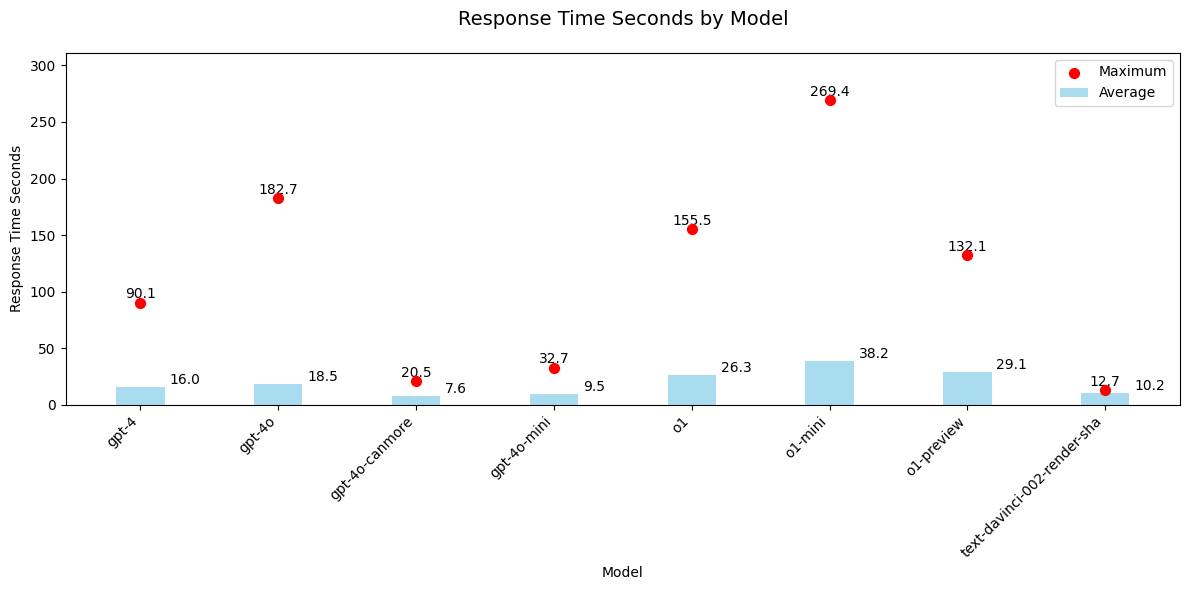

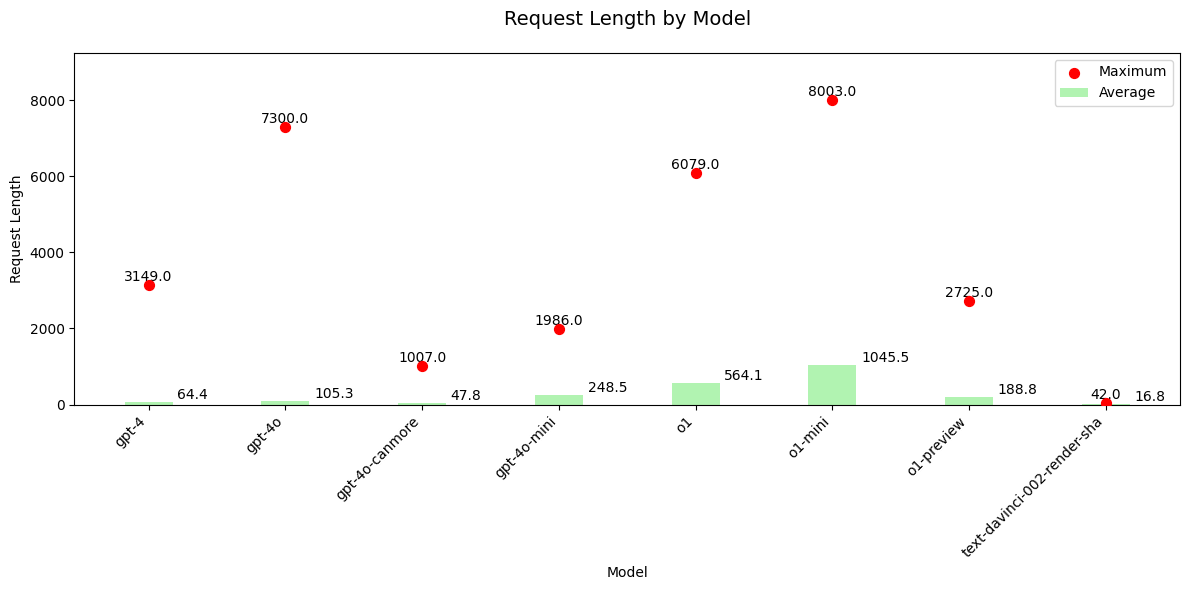

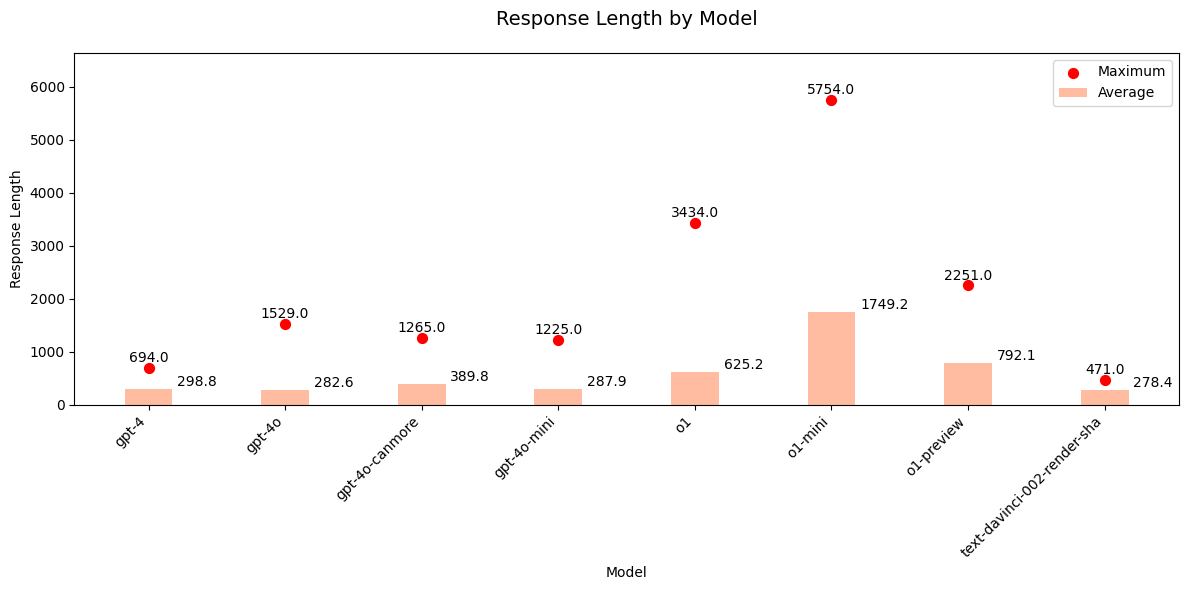

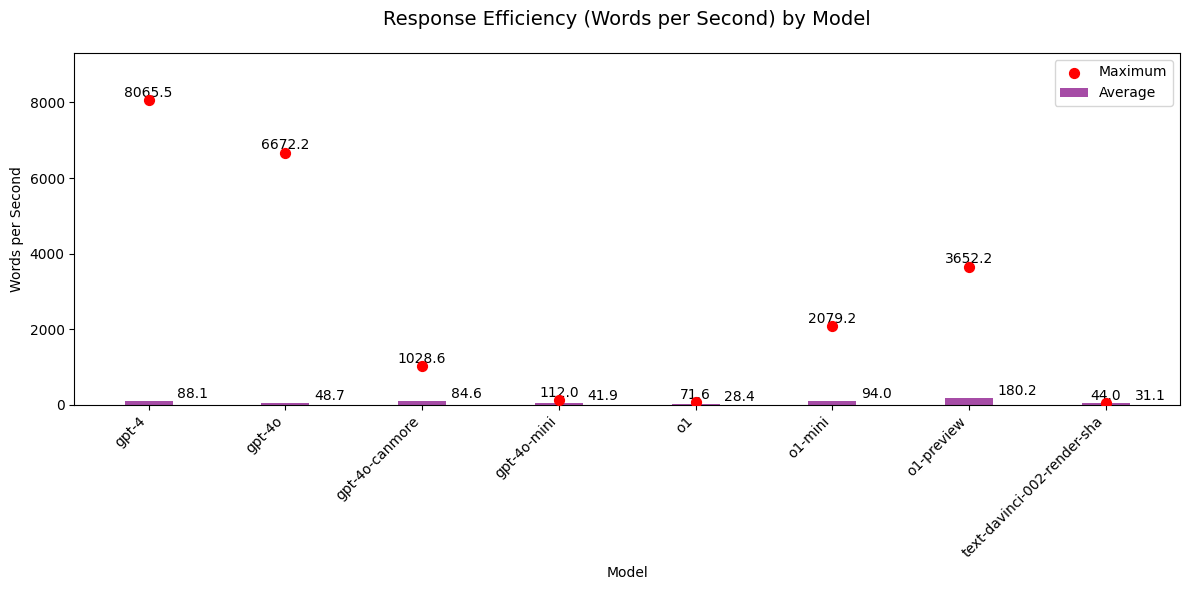

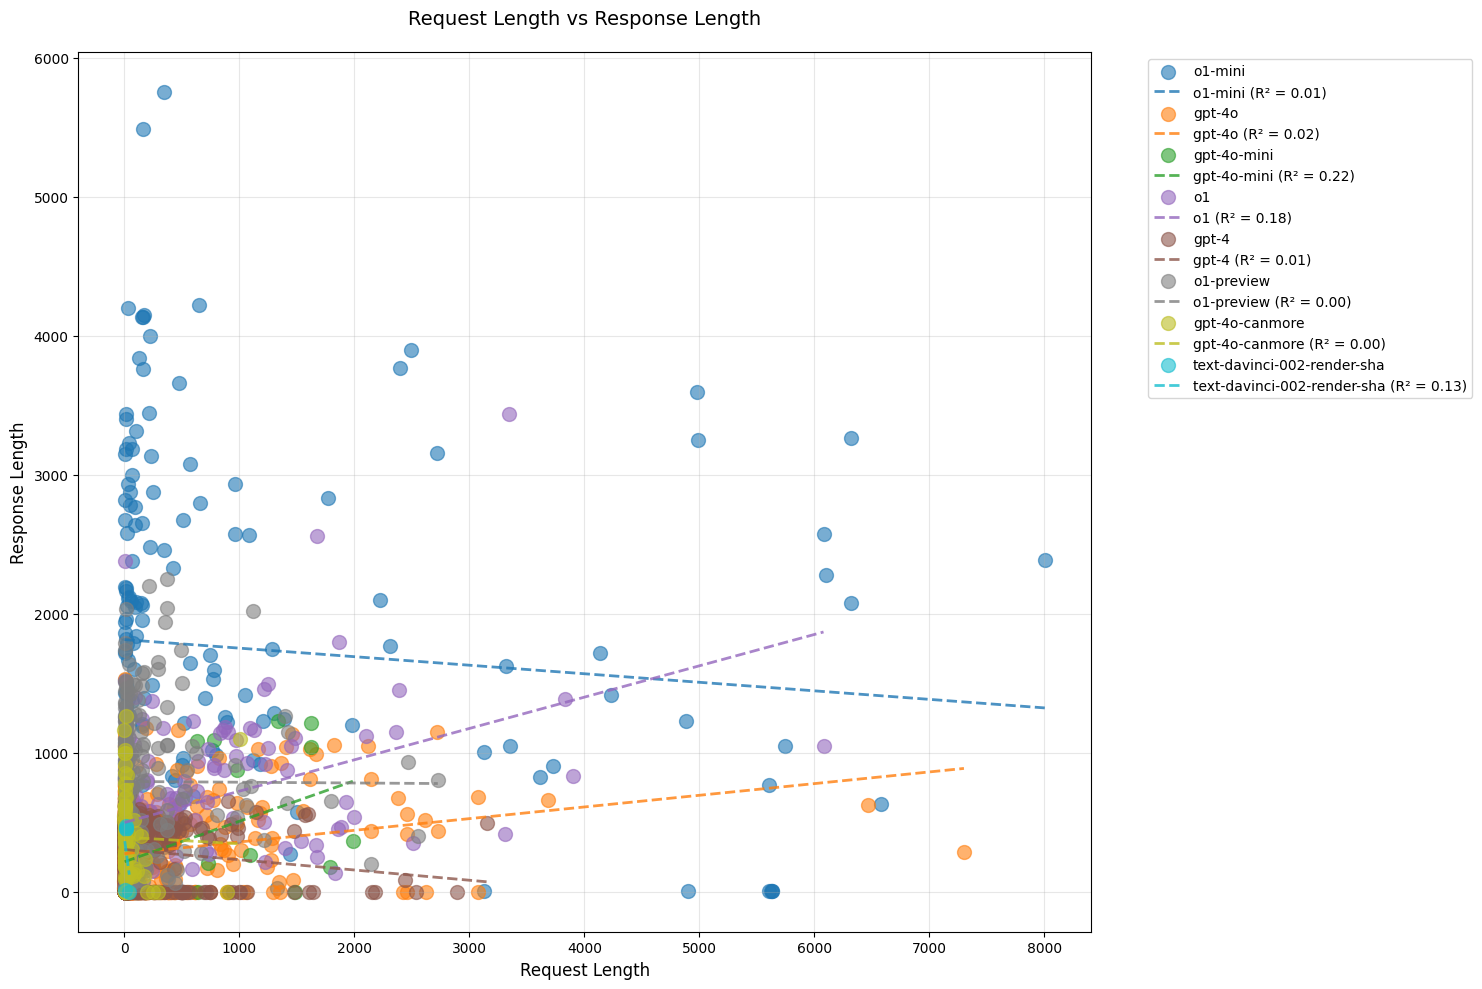

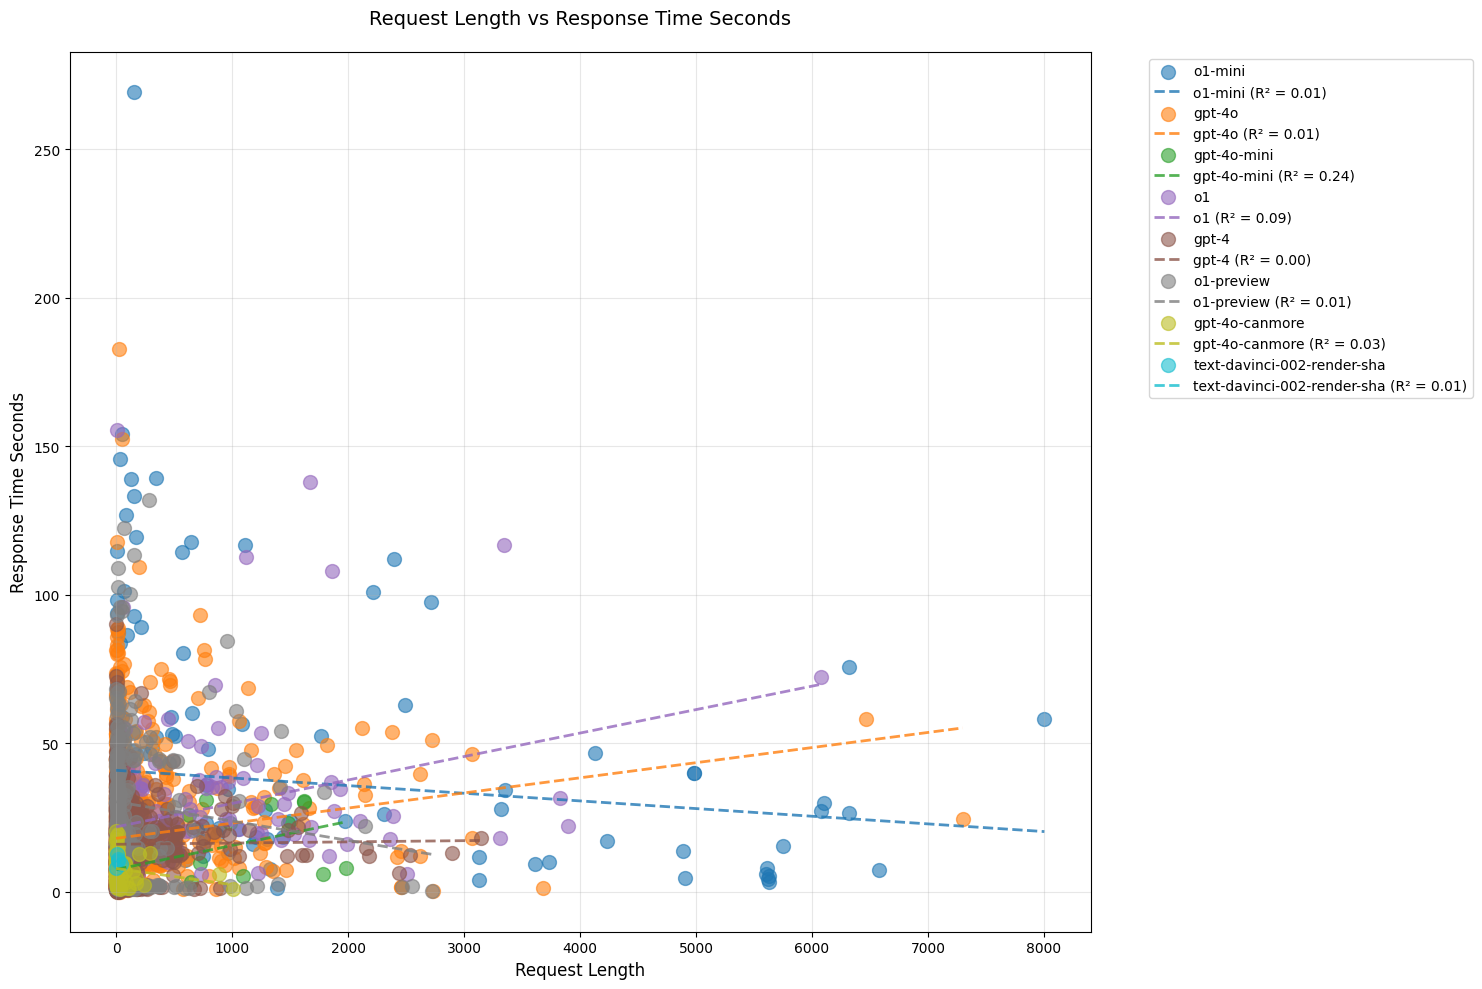

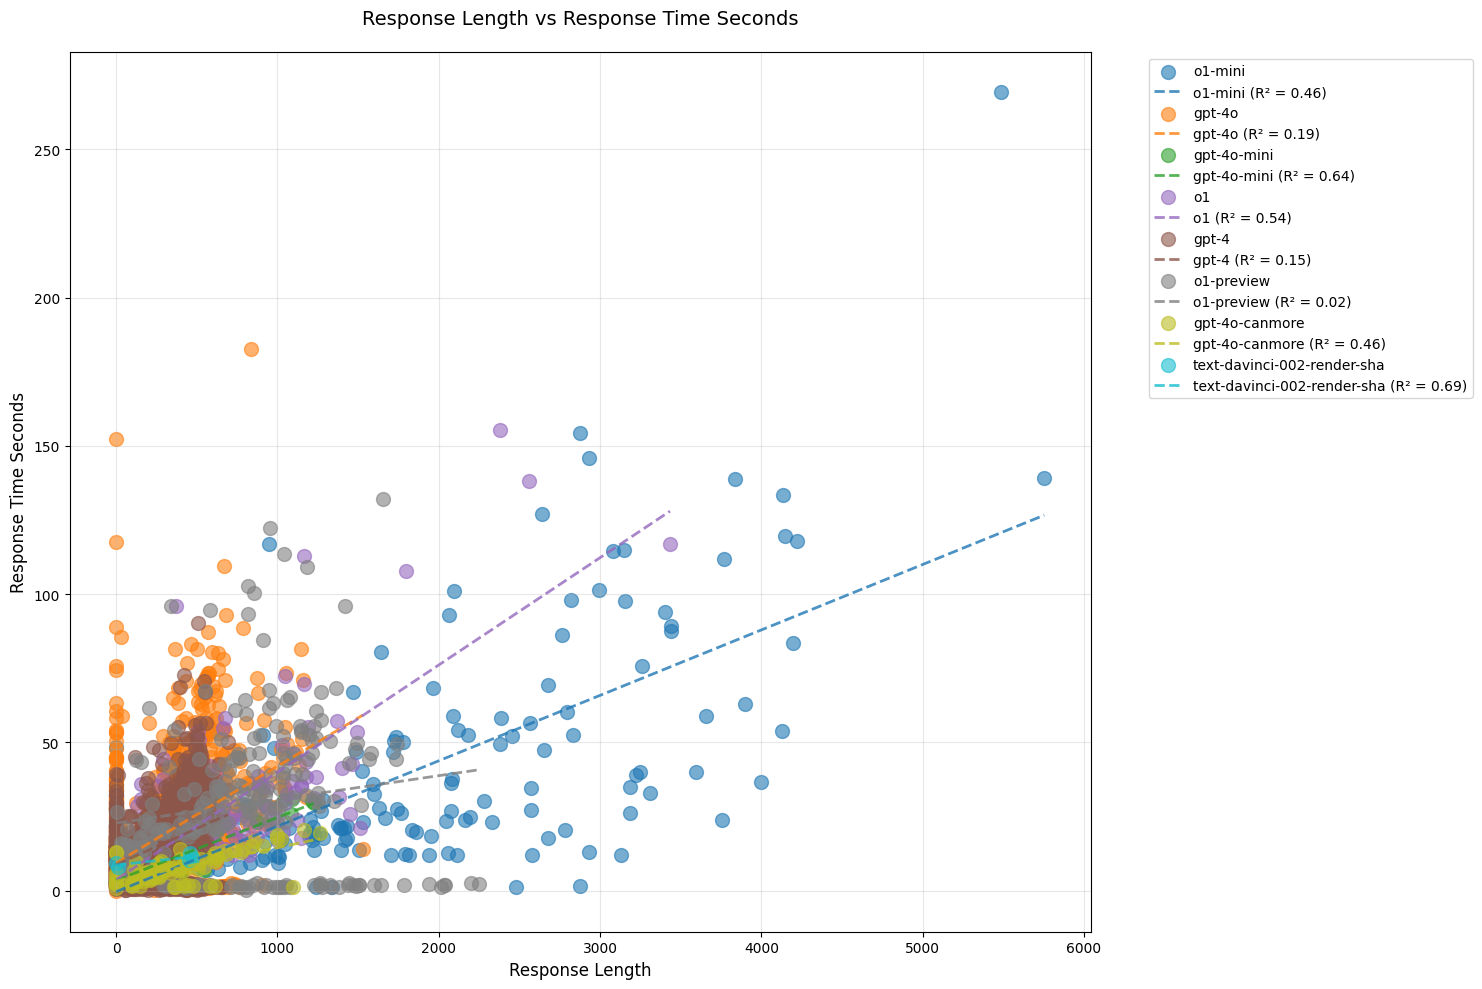


Response Time Statistics by Model (seconds):
                    model_slug       mean         max
0                        gpt-4  16.005587   90.119104
1                       gpt-4o  18.525449  182.668882
2               gpt-4o-canmore   7.597694   20.478762
3                  gpt-4o-mini   9.509070   32.679195
4                           o1  26.285388  155.510467
5                      o1-mini  38.207487  269.440724
6                   o1-preview  29.079329  132.085920
7  text-davinci-002-render-sha  10.238794   12.690302

Request Length Statistics by Model (words):
                    model_slug         mean   max
0                        gpt-4    64.387701  3149
1                       gpt-4o   105.315537  7300
2               gpt-4o-canmore    47.769231  1007
3                  gpt-4o-mini   248.476923  1986
4                           o1   564.119497  6079
5                      o1-mini  1045.544910  8003
6                   o1-preview   188.761702  2725
7  text-davinci-002-ren

In [3]:
# First calculate response times
def calculate_time_diff(row):
    if row['user_message_id'] in message_dict and row['assistant_message_id'] in message_dict:
        user_msg = message_dict[row['user_message_id']]
        assistant_msg = message_dict[row['assistant_message_id']]
        
        user_time = user_msg.get('message_create_time')
        assistant_time = assistant_msg.get('message_create_time')
        
        if pd.notna(user_time) and pd.notna(assistant_time):
            try:
                # Calculate time difference in seconds
                time_diff = (assistant_time - user_time).total_seconds()
                return time_diff if time_diff > 0 else None
            except:
                return None
    return None

# Calculate word counts
def get_word_count(msg_id):
    if msg_id not in message_dict:
        return 0
    content = message_dict[msg_id].get('content', '')
    if isinstance(content, dict) and 'parts' in content:
        return len(' '.join(str(part) for part in content['parts'] if part).split())
    return len(str(content).split())

# Add metrics to mapping_df
mapping_df['response_time_seconds'] = mapping_df.apply(calculate_time_diff, axis=1)
mapping_df['request_length'] = mapping_df['user_message_id'].apply(get_word_count)
mapping_df['response_length'] = mapping_df['assistant_message_id'].apply(get_word_count)

# Print some basic info about the data
print("\nData shape:", mapping_df.shape)
print("\nNull values in each column:")
print(mapping_df.isnull().sum())
print("\nSample of the first few rows:")
print(mapping_df[['response_time_seconds', 'request_length', 'response_length', 'model_slug']].head())
# Function to add value labels on bars and points with improved positioning
def add_value_labels(ax, bars, points, bar_width):
    # Add labels for bars - shifted slightly to the right
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() + bar_width*0.1, height,
                f'{height:.1f}',
                ha='left', va='bottom', fontsize=10)
    
    # Add labels for scatter points with adjusted position
    max_height = max(bar.get_height() for bar in bars)
    offsets = points.get_offsets()
    for x, y in offsets:
        # Position the text above the point with some padding
        label_y = y + max_height * 0.03
        ax.text(x, label_y, f'{y:.1f}',
                ha='center', va='bottom', fontsize=10)
        
    # Adjust ylim to accommodate labels
    current_ymax = ax.get_ylim()[1]
    ax.set_ylim(top=current_ymax * 1.1)

# Function for regression line with color matching
def add_regression_line(ax, x, y, color, label):
    mask = ~np.isnan(x) & ~np.isnan(y)
    if len(x[mask]) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
        line_x = np.array([min(x[mask]), max(x[mask])])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, color=color, linestyle='--', alpha=0.8, linewidth=2,
                label=f'{label} (R² = {r_value**2:.2f})')
        return r_value**2
    return None

# Create Column Charts
def create_column_chart(data, metric_name, color):
    # Drop null values for the specific metric
    data_clean = data.dropna(subset=[metric_name, 'model_slug'])
    
    # Only proceed if we have data
    if len(data_clean) == 0:
        print(f"No valid data for {metric_name}")
        return None
        
    fig, ax = plt.subplots(figsize=(12, 6))
    stats = data_clean.groupby('model_slug')[metric_name].agg(['mean', 'max']).reset_index()
    bar_positions = np.arange(len(stats))
    bar_width = 0.35

    bars = ax.bar(bar_positions, stats['mean'], bar_width, alpha=0.7, label='Average', color=color)
    points = ax.scatter(bar_positions, stats['max'], color='red', s=50, label='Maximum', zorder=5)
    add_value_labels(ax, bars, points, bar_width)

    ax.set_title(f'{metric_name.replace('_', ' ').title()} by Model', fontsize=14, pad=20)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric_name.replace('_', ' ').title())
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(stats['model_slug'], rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()
    return stats

# Create Scatter Plots with per-model regression lines
def create_scatter_plot(data, x_col, y_col):
    # Drop null values for both columns
    data_clean = data.dropna(subset=[x_col, y_col, 'model_slug'])
    
    # Only proceed if we have data
    if len(data_clean) == 0:
        print(f"No valid data for {x_col} vs {y_col}")
        return
        
    fig, ax = plt.subplots(figsize=(15, 10))
    colors = plt.cm.tab10(np.linspace(0, 1, len(data_clean['model_slug'].unique())))
    
    for model, color in zip(data_clean['model_slug'].unique(), colors):
        model_data = data_clean[data_clean['model_slug'] == model]
        ax.scatter(model_data[x_col], model_data[y_col], 
                   label=model, alpha=0.6, color=color, s=100)
        # Add regression line for each model
        add_regression_line(ax, model_data[x_col], model_data[y_col], color, model)

    ax.set_title(f'{x_col.replace("_", " ").title()} vs {y_col.replace("_", " ").title()}', 
              fontsize=14, pad=20)
    ax.set_xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel(y_col.replace('_', ' ').title(), fontsize=12)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Calculate efficiency ratio
def create_efficiency_ratio_chart(data):
    # Create a copy to avoid modifying the original dataframe
    data_clean = data.copy()
    
    # Calculate words per second ratio where both values are available
    mask = (data_clean['response_length'] > 0) & (data_clean['response_time_seconds'] > 0)
    data_clean.loc[mask, 'efficiency_ratio'] = (
        data_clean.loc[mask, 'response_length'] / data_clean.loc[mask, 'response_time_seconds']
    )
    
    # Drop rows where we couldn't calculate the ratio
    data_clean = data_clean.dropna(subset=['efficiency_ratio', 'model_slug'])
    
    # Only proceed if we have data
    if len(data_clean) == 0:
        print("No valid data for efficiency ratio")
        return None
        
    fig, ax = plt.subplots(figsize=(12, 6))
    ratio_stats = data_clean.groupby('model_slug')['efficiency_ratio'].agg(['mean', 'max']).reset_index()
    
    bar_positions = np.arange(len(ratio_stats))
    bar_width = 0.35

    bars = ax.bar(bar_positions, ratio_stats['mean'], bar_width, alpha=0.7, 
                 label='Average', color='purple')
    points = ax.scatter(bar_positions, ratio_stats['max'], color='red', 
                       s=50, label='Maximum', zorder=5)
    add_value_labels(ax, bars, points, bar_width)

    ax.set_title('Response Efficiency (Words per Second) by Model', fontsize=14, pad=20)
    ax.set_xlabel('Model')
    ax.set_ylabel('Words per Second')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(ratio_stats['model_slug'], rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()
    return ratio_stats

# Create all plots
# Column charts
response_stats = create_column_chart(mapping_df, 'response_time_seconds', 'skyblue')
request_stats = create_column_chart(mapping_df, 'request_length', 'lightgreen')
response_length_stats = create_column_chart(mapping_df, 'response_length', 'lightsalmon')
efficiency_stats = create_efficiency_ratio_chart(mapping_df)

# Scatter plots
create_scatter_plot(mapping_df, 'request_length', 'response_length')
create_scatter_plot(mapping_df, 'request_length', 'response_time_seconds')
create_scatter_plot(mapping_df, 'response_length', 'response_time_seconds')

# Print summary statistics
if response_stats is not None:
    print("\nResponse Time Statistics by Model (seconds):")
    print(response_stats)
if request_stats is not None:
    print("\nRequest Length Statistics by Model (words):")
    print(request_stats)
if response_length_stats is not None:
    print("\nResponse Length Statistics by Model (words):")
    print(response_length_stats)
if efficiency_stats is not None:
    print("\nEfficiency Ratio Statistics by Model (words per second):")
    print(efficiency_stats)


Overall Model Slug Distribution:
                    model_slug  count  percentage
0                       gpt-4o   2044       44.45
1                        gpt-4   1790       38.93
2                   o1-preview    241        5.24
3                      o1-mini    169        3.68
4                           o1    158        3.44
5               gpt-4o-canmore    103        2.24
6                  gpt-4o-mini     86        1.87
7  text-davinci-002-render-sha      7        0.15

Total Usage:
4598


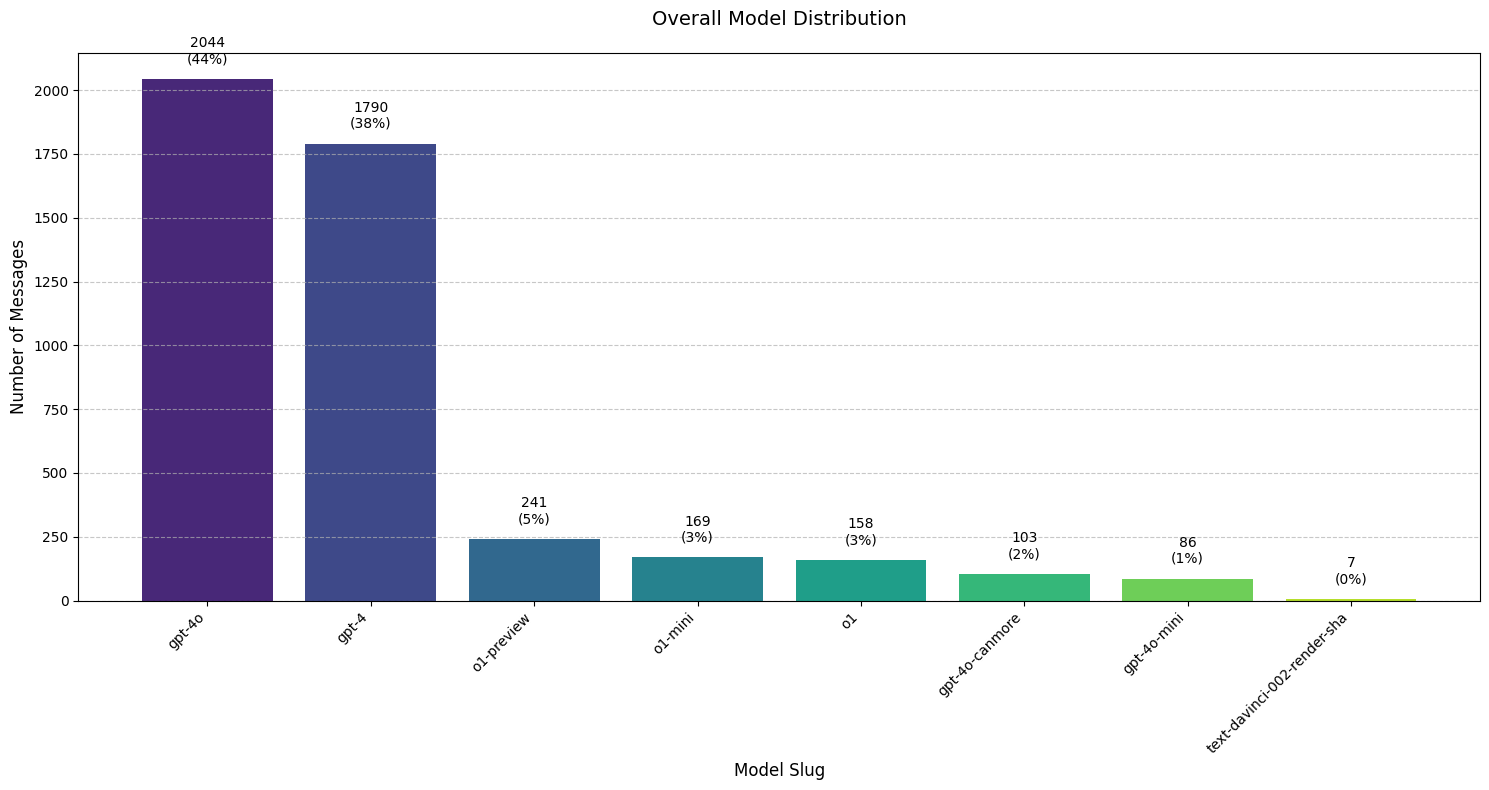

<Figure size 2000x1200 with 0 Axes>

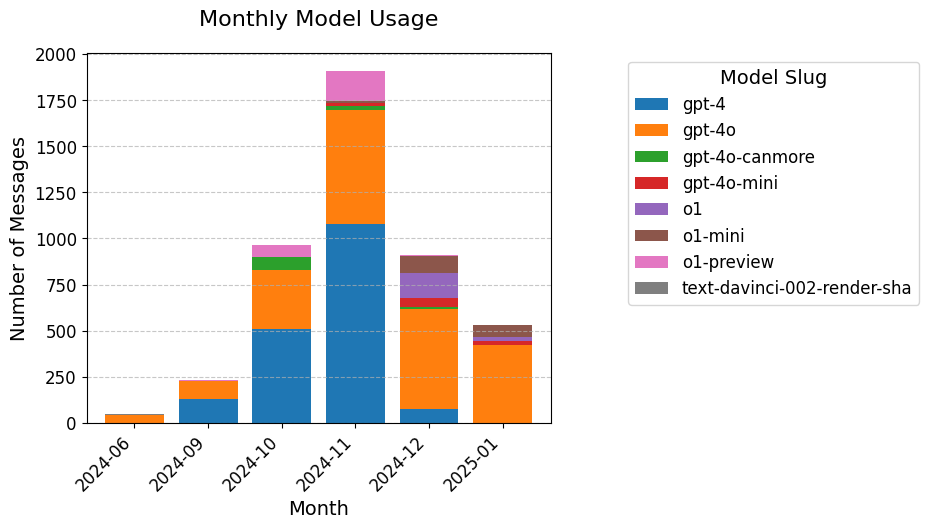


Monthly Usage Percentages:
model_slug  gpt-4  gpt-4o  gpt-4o-canmore  gpt-4o-mini     o1  o1-mini  \
month                                                                    
2024-06      0.00   85.71            0.00         0.00   0.00     0.00   
2024-09     55.36   42.92            0.00         0.00   0.00     0.00   
2024-10     52.54   33.58            6.84         0.31   0.00     0.00   
2024-11     56.39   32.39            1.31         0.73   0.00     0.52   
2024-12      8.56   58.95            1.32         5.49  14.71    10.21   
2025-01      0.00   79.51            0.00         3.57   4.51    12.41   

model_slug  o1-preview  text-davinci-002-render-sha  
month                                                
2024-06           0.00                        14.29  
2024-09           1.72                         0.00  
2024-10           6.74                         0.00  
2024-11           8.65                         0.00  
2024-12           0.77                         0.00  
2

In [21]:

# Get only the assistant messages that have valid responses
valid_assistant_responses = df[df['role'] == 'assistant'].copy()

# Add month information to valid responses
valid_assistant_responses['month'] = pd.to_datetime(valid_assistant_responses['message_create_time']).dt.to_period('M')

# Overall model distribution
model_slug_counts = valid_assistant_responses['model_slug'].value_counts().reset_index()
model_slug_counts.columns = ['model_slug', 'count']

# Calculate overall percentages
total_messages = model_slug_counts['count'].sum()
model_slug_counts['percentage'] = (model_slug_counts['count'] / total_messages * 100).round(2)

print("\nOverall Model Slug Distribution:")
print(model_slug_counts)
print("\nTotal Usage:")
print(total_messages)

# Calculate monthly usage
monthly_usage = valid_assistant_responses.groupby(['month', 'model_slug']).size().unstack(fill_value=0)

# Calculate monthly percentages
monthly_percentages = monthly_usage.div(monthly_usage.sum(axis=1), axis=0) * 100

# 1. Overall distribution
plt.figure(figsize=(15, 8))
bars = plt.bar(
    model_slug_counts['model_slug'],
    model_slug_counts['count'],
    color=sns.color_palette('viridis', n_colors=len(model_slug_counts))
)

# Add value labels to bars with adjusted positioning
for bar in bars:
    height = bar.get_height()  # Get the height of the bar
    percentage = model_slug_counts.loc[model_slug_counts["count"] == height, "percentage"].values
    percentage_text = f'{int(percentage[0])}%' if len(percentage) > 0 else 'N/A'
    
    # Add text above the bar with slight padding
    plt.text(
        bar.get_x() + bar.get_width() / 2.,  # Center the text
        height + 50,  # Adjust height by adding padding (e.g., 50)
        f'{int(height)}\n({percentage_text})',  # Display count and percentage
        ha='center',  # Align horizontally to center
        va='bottom',  # Align vertically at the bottom of the text
    )

# Configure plot labels and styling
plt.title('Overall Model Distribution', fontsize=14, pad=20)
plt.xlabel('Model Slug', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 2. Monthly distribution - Much larger plot with adjusted layout
plt.figure(figsize=(20, 12))  # Increased figure size
ax = monthly_usage.plot(
    kind='bar', 
    stacked=True,
    width=0.8  # Slightly wider bars
)

plt.title('Monthly Model Usage', fontsize=16, pad=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Messages', fontsize=14)

# Adjust legend
plt.legend(
    title='Model Slug',
    bbox_to_anchor=(1.15, 1),
    loc='upper left',
    fontsize=12,
    title_fontsize=14
)

# Enhance grid and labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout to prevent legend cutoff
plt.subplots_adjust(right=0.85)
plt.show()

# Print monthly percentages
print("\nMonthly Usage Percentages:")
print(monthly_percentages.round(2))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BatuhanZencir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Analyzing User Queries ===


C:\Users\BatuhanZencir\AppData\Local\Temp\ipykernel_12240\3528250771.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_words, x='Frequency', y='Word', palette='viridis')


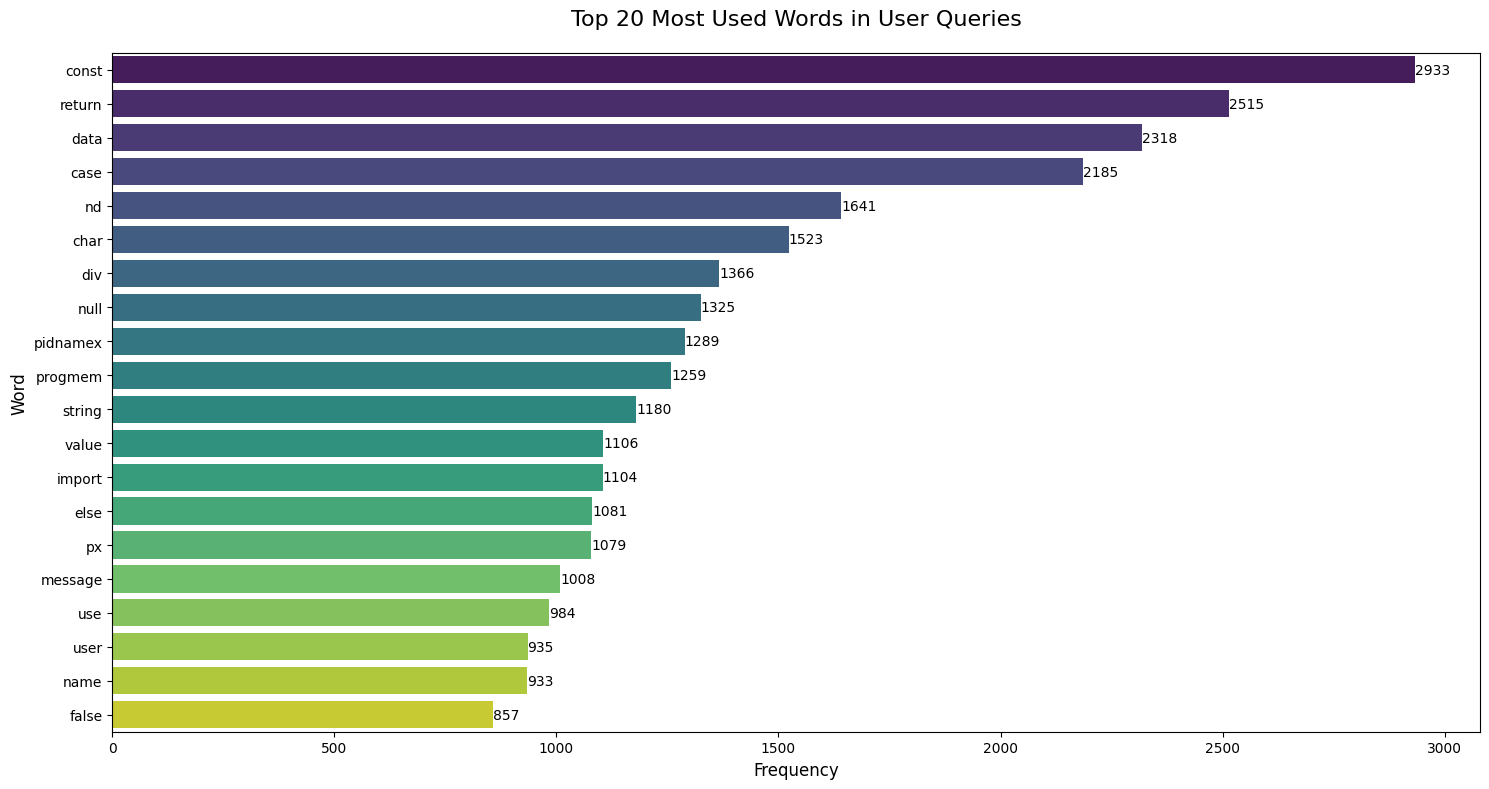


Statistics for User Queries:
Total words (including stopwords): 504813
Unique words (including stopwords): 27705
Total words (after filtering): 357445
Unique words (after filtering): 27534

=== Analyzing Assistant Responses ===


C:\Users\BatuhanZencir\AppData\Local\Temp\ipykernel_12240\3528250771.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_words, x='Frequency', y='Word', palette='viridis')


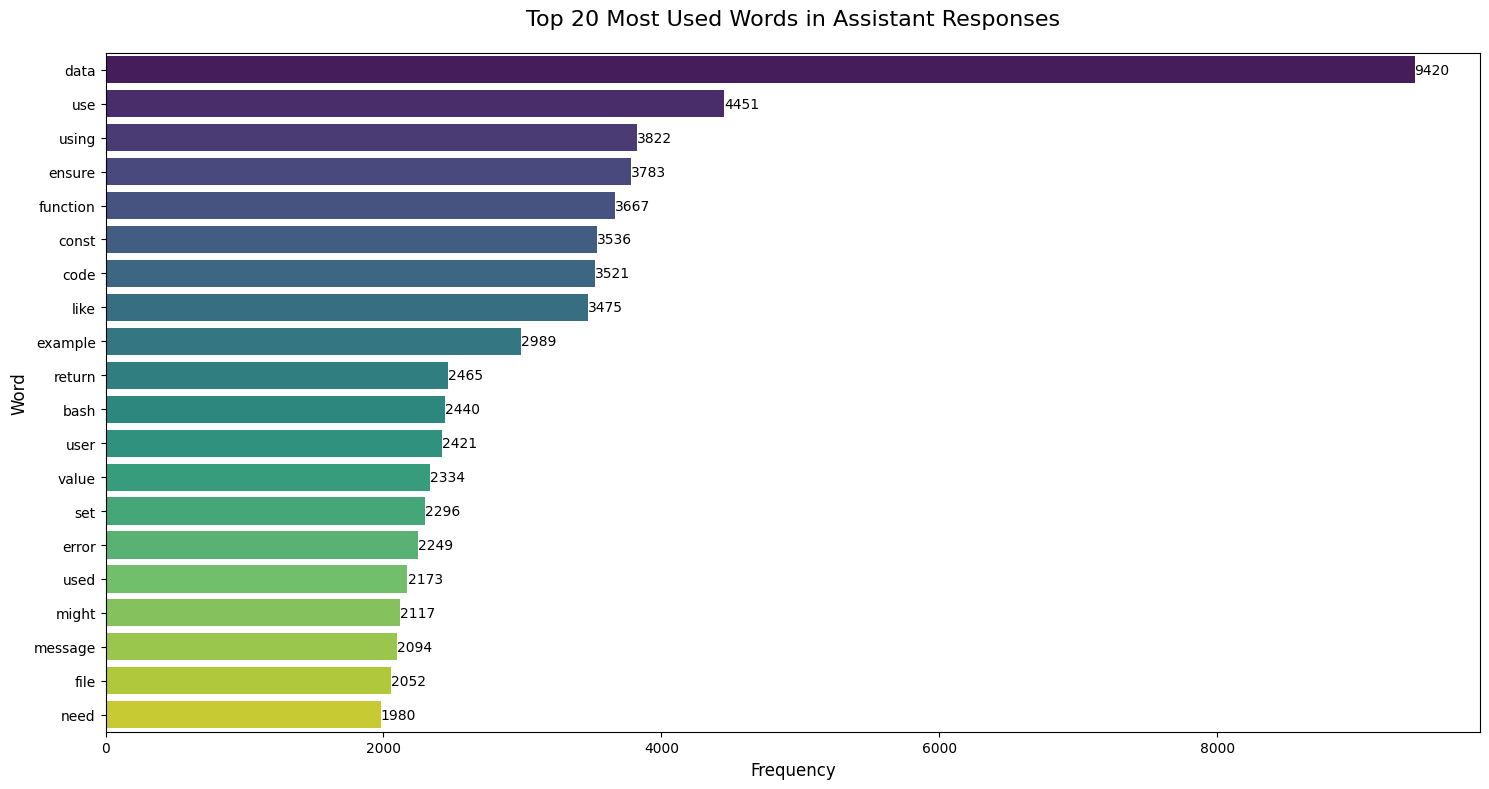


Statistics for Assistant Responses:
Total words (including stopwords): 1344919
Unique words (including stopwords): 37660
Total words (after filtering): 895885
Unique words (after filtering): 37489

=== Word Frequency Comparison ===

Words more frequent in Assistant responses:
        Word  User Frequency  Assistant Frequency  Frequency Difference
5       data          2318.0               9420.0                7102.0
31     using             0.0               3822.0                3822.0
8     ensure             0.0               3783.0                3783.0
13  function             0.0               3667.0                3667.0
3       code             0.0               3521.0                3521.0
15      like             0.0               3475.0                3475.0
28       use           984.0               4451.0                3467.0
10   example             0.0               2989.0                2989.0
0       bash             0.0               2440.0                2440.0
26

In [5]:

nltk.download('stopwords')
from nltk.corpus import stopwords

def analyze_word_frequencies(mapping_df, message_dict, message_type='user'):
    # Get stopwords for multiple languages
    stop_words = set()
    languages = ['english', 'turkish']
    for lang in languages:
        try:
            stop_words.update(stopwords.words(lang))
        except:
            print(f"Warning: Stopwords for {lang} not available")
    
    # Get messages content
    def get_message_content(msg_id):
        if msg_id in message_dict:
            content = message_dict[msg_id].get('content', '')
            if isinstance(content, dict) and 'parts' in content:
                return ' '.join(str(part) for part in content['parts'] if part)
            return str(content)
        return ''
    
    # Get messages based on type
    message_id_column = 'user_message_id' if message_type == 'user' else 'assistant_message_id'
    messages = [get_message_content(msg_id) for msg_id in mapping_df[message_id_column]]
    
    # Preprocess text
    def preprocess_text(text):
        # Convert to lowercase
        text = str(text).lower()
        
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove digits
        text = re.sub(r'\d+', '', text)
        
        # Remove non-ASCII characters
        text = text.encode('ascii', 'ignore').decode('ascii')
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    # Combine all messages and preprocess
    all_text = ' '.join(messages)
    clean_text = preprocess_text(all_text)
    
    # Tokenize and remove stopwords
    words = clean_text.split()
    filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
    
    # Count word frequencies
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(20)
    
    # Create DataFrame for visualization
    df_top_words = pd.DataFrame(top_words, columns=['Word', 'Frequency'])
    
    # Create visualization
    plt.figure(figsize=(15, 8))
    sns.barplot(data=df_top_words, x='Frequency', y='Word', palette='viridis')
    plt.title(f'Top 20 Most Used Words in {message_type.title()} {"Queries" if message_type == "user" else "Responses"}', 
              fontsize=16, pad=20)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Word', fontsize=12)
    
    # Add value labels on bars
    for i, v in enumerate(df_top_words['Frequency']):
        plt.text(v + 0.1, i, str(v), va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print total word count statistics
    total_words = len(words)
    unique_words = len(set(words))
    print(f"\nStatistics for {message_type.title()} {'Queries' if message_type == 'user' else 'Responses'}:")
    print(f"Total words (including stopwords): {total_words}")
    print(f"Unique words (including stopwords): {unique_words}")
    print(f"Total words (after filtering): {len(filtered_words)}")
    print(f"Unique words (after filtering): {len(set(filtered_words))}")
    
    return df_top_words

# Compare both types of messages
print("\n=== Analyzing User Queries ===")
user_word_frequencies = analyze_word_frequencies(mapping_df, message_dict, 'user')
print("\n=== Analyzing Assistant Responses ===")
assistant_word_frequencies = analyze_word_frequencies(mapping_df, message_dict, 'assistant')

# Create a comparison DataFrame
print("\n=== Word Frequency Comparison ===")
comparison = pd.merge(
    user_word_frequencies.rename(columns={'Frequency': 'User Frequency'}),
    assistant_word_frequencies.rename(columns={'Frequency': 'Assistant Frequency'}),
    on='Word', how='outer'
).fillna(0)
comparison['Frequency Difference'] = comparison['Assistant Frequency'] - comparison['User Frequency']
comparison = comparison.sort_values('Frequency Difference', ascending=False)
print("\nWords more frequent in Assistant responses:")
print(comparison[comparison['Frequency Difference'] > 0].head(10))
print("\nWords more frequent in User queries:")
print(comparison[comparison['Frequency Difference'] < 0].head(10))

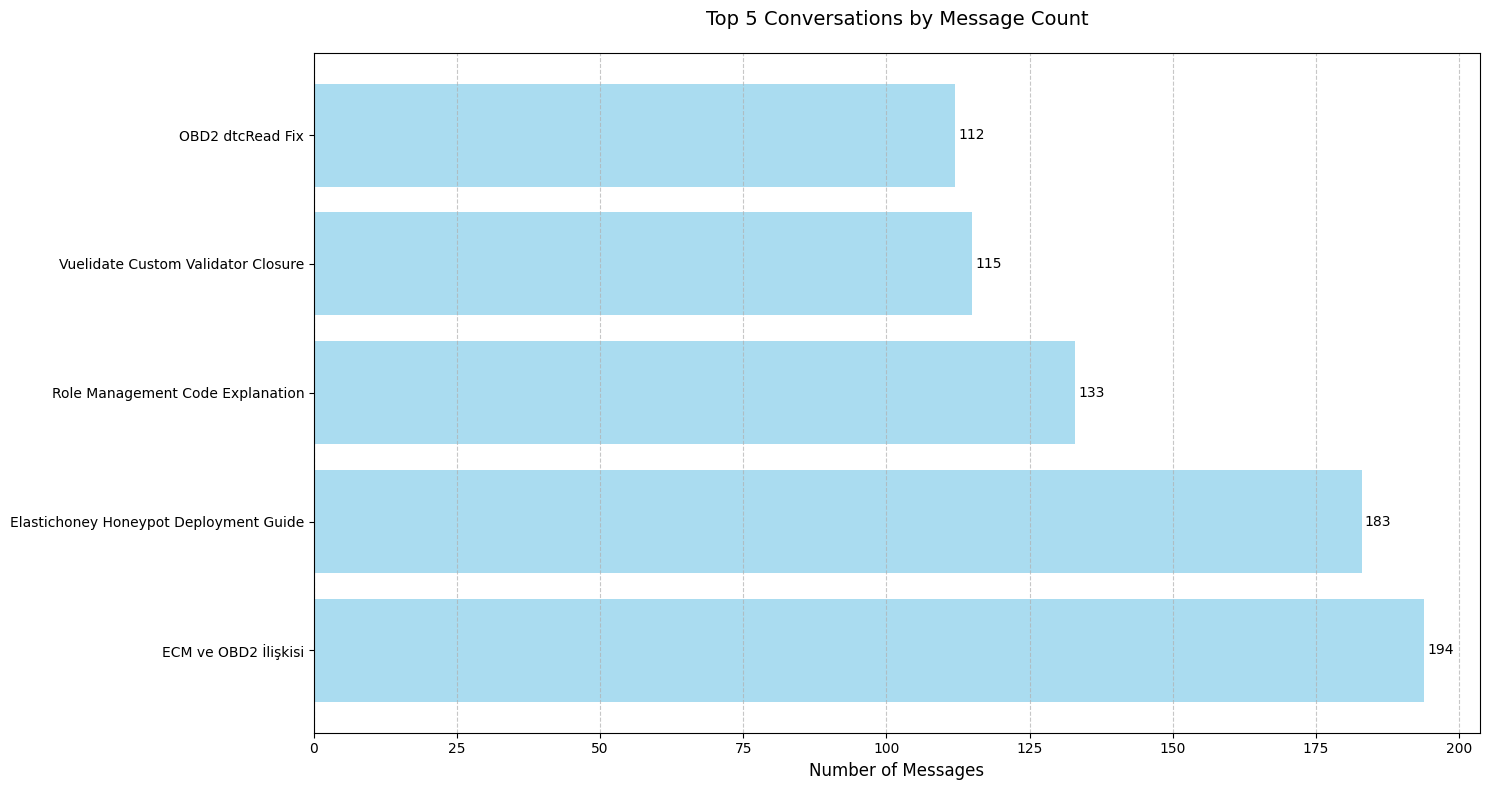


Top 5 Conversations by Message Count:
----------------------------------------------------------------------------------------------------
Title: ECM ve OBD2 İlişkisi
Messages: 194
----------------------------------------------------------------------------------------------------
Title: Elastichoney Honeypot Deployment Guide
Messages: 183
----------------------------------------------------------------------------------------------------
Title: Role Management Code Explanation
Messages: 133
----------------------------------------------------------------------------------------------------
Title: Vuelidate Custom Validator Closure
Messages: 115
----------------------------------------------------------------------------------------------------
Title: OBD2 dtcRead Fix
Messages: 112
----------------------------------------------------------------------------------------------------


In [7]:

from textwrap import wrap
with open('conversations.json', 'r', encoding='utf-8') as file:
    conversations_data = json.load(file)

# Get top 5 conversations data
def get_top_conversations(conversations_data, n=5):
    conversations = {}
    
    # Iterate through conversations to get titles and count messages
    for conversation in conversations_data:
        title = conversation.get('title', 'No Title')
        mapping = conversation.get('mapping', {})
        message_count = len([msg for msg in mapping.values() if msg.get('message') is not None])
        conversations[title] = message_count
    
    # Convert to DataFrame and sort
    conv_df = pd.DataFrame(list(conversations.items()), columns=['title', 'message_count'])
    return conv_df.nlargest(n, 'message_count')

# Get top 5 conversations
top_5 = get_top_conversations(conversations_data)

# Create figure with adjusted size
plt.figure(figsize=(15, 8))

# Create horizontal bar chart
bars = plt.barh(range(len(top_5)), top_5['message_count'], color='skyblue', alpha=0.7)

# Add value labels on the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             str(int(bar.get_width())), 
             va='center',
             fontsize=10)

# Customize the plot
plt.title('Top 5 Conversations by Message Count', fontsize=14, pad=20)
plt.xlabel('Number of Messages', fontsize=12)

# Set y-axis labels with wrapped titles for better readability
wrapped_titles = ['\n'.join(wrap(str(title), width=50)) for title in top_5['title']]
plt.yticks(range(len(top_5)), wrapped_titles, fontsize=10)

# Add grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent cutoff
plt.subplots_adjust(left=0.4)  # Give more space for titles
plt.tight_layout()

plt.show()

# Print the data
print("\nTop 5 Conversations by Message Count:")
print("-" * 100)
for _, row in top_5.iterrows():
    print(f"Title: {row['title']}")
    print(f"Messages: {row['message_count']}")
    print("-" * 100)

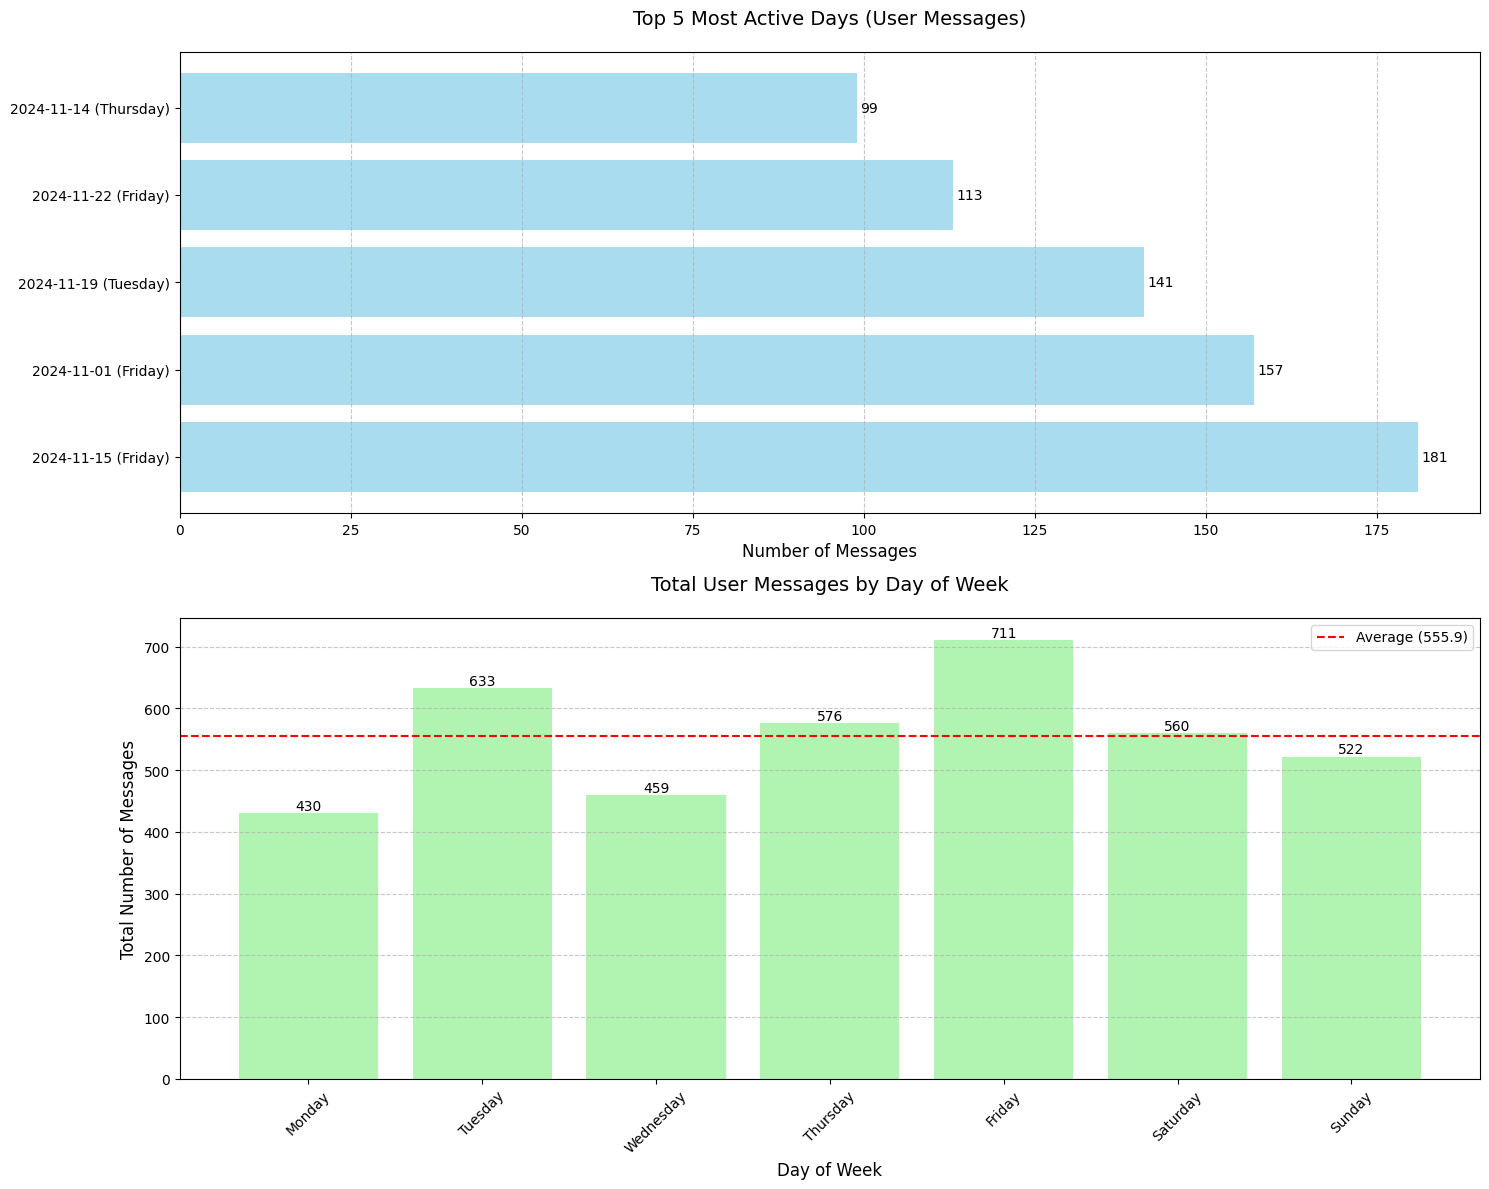


Top 5 Most Active Days (User Messages):
Date: 2024-11-15 (Friday)
Messages: 181
----------------------------------------
Date: 2024-11-01 (Friday)
Messages: 157
----------------------------------------
Date: 2024-11-19 (Tuesday)
Messages: 141
----------------------------------------
Date: 2024-11-22 (Friday)
Messages: 113
----------------------------------------
Date: 2024-11-14 (Thursday)
Messages: 99
----------------------------------------

Day of Week Statistics (User Messages):
Most active day: Friday
Least active day: Monday
Average messages per day: 555.9
Total messages: 3891


In [9]:

from datetime import datetime

# Create messages DataFrame with only user messages
df_messages = df[df['role'] == 'user'][['message_id', 'message_create_time']].copy()
df_messages['datetime'] = pd.to_datetime(df_messages['message_create_time'])
df_messages['day_name'] = df_messages['datetime'].dt.strftime('%A')

# Calculate messages per specific day
daily_counts = df_messages.groupby(df_messages['datetime'].dt.date).size().reset_index()
daily_counts.columns = ['date', 'message_count']
daily_counts['day_name'] = daily_counts['date'].apply(lambda x: x.strftime('%A'))

# Calculate messages per day of week
weekly_counts = df_messages.groupby('day_name').size().reset_index()
weekly_counts.columns = ['day_name', 'message_count']

# Ensure proper day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_counts['day_name'] = pd.Categorical(weekly_counts['day_name'], categories=day_order, ordered=True)
weekly_counts = weekly_counts.sort_values('day_name')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Top 5 Most Active Days
top_5_days = daily_counts.nlargest(5, 'message_count')
bars1 = ax1.barh(range(len(top_5_days)), top_5_days['message_count'], color='skyblue', alpha=0.7)

# Add value labels
for i, bar in enumerate(bars1):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             str(int(bar.get_width())),
             va='center')

# Customize first plot
ax1.set_title('Top 5 Most Active Days (User Messages)', fontsize=14, pad=20)
ax1.set_xlabel('Number of Messages', fontsize=12)
labels = [f"{date.strftime('%Y-%m-%d')} ({day})" 
          for date, day in zip(top_5_days['date'], top_5_days['day_name'])]
ax1.set_yticks(range(len(top_5_days)))
ax1.set_yticklabels(labels)
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Plot 2: Day of Week Analysis
bars2 = ax2.bar(weekly_counts['day_name'], weekly_counts['message_count'],
                color='lightgreen', alpha=0.7)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}',
             ha='center', va='bottom')

# Customize second plot
ax2.set_title('Total User Messages by Day of Week', fontsize=14, pad=20)
ax2.set_xlabel('Day of Week', fontsize=12)
ax2.set_ylabel('Total Number of Messages', fontsize=12)
plt.xticks(rotation=45)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add average line to day of week plot
avg_messages = weekly_counts['message_count'].mean()
ax2.axhline(y=avg_messages, color='red', linestyle='--',
            label=f'Average ({avg_messages:.1f})')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Print statistics
print("\nTop 5 Most Active Days (User Messages):")
print("=" * 60)
for _, row in top_5_days.iterrows():
    print(f"Date: {row['date'].strftime('%Y-%m-%d')} ({row['day_name']})")
    print(f"Messages: {row['message_count']}")
    print("-" * 40)

print("\nDay of Week Statistics (User Messages):")
print("=" * 60)
print(f"Most active day: {weekly_counts.iloc[weekly_counts['message_count'].argmax()]['day_name']}")
print(f"Least active day: {weekly_counts.iloc[weekly_counts['message_count'].argmin()]['day_name']}")
print(f"Average messages per day: {weekly_counts['message_count'].mean():.1f}")
print(f"Total messages: {weekly_counts['message_count'].sum()}")


Overall Average Messages per Day: 35.05

Exam Day Message Analysis:
     Exam_Date     Description  Total_Messages  Percentage_Difference  \
0   2024-11-09  Midterm period              48                  36.93   
1   2024-11-10  Midterm period              15                 -57.21   
2   2024-11-11  Midterm period              56                  59.75   
3   2024-11-12  Midterm period              62                  76.87   
4   2025-01-01   Finals period              52                  48.34   
5   2025-01-02   Finals period              48                  36.93   
6   2025-01-03   Finals period              12                 -65.77   
7   2025-01-04   Finals period              50                  42.64   
8   2025-01-05   Finals period              78                 122.51   
9   2025-01-06   Finals period              10                 -71.47   
10  2025-01-07   Finals period              76                 116.81   
11  2025-01-08   Finals period               4         

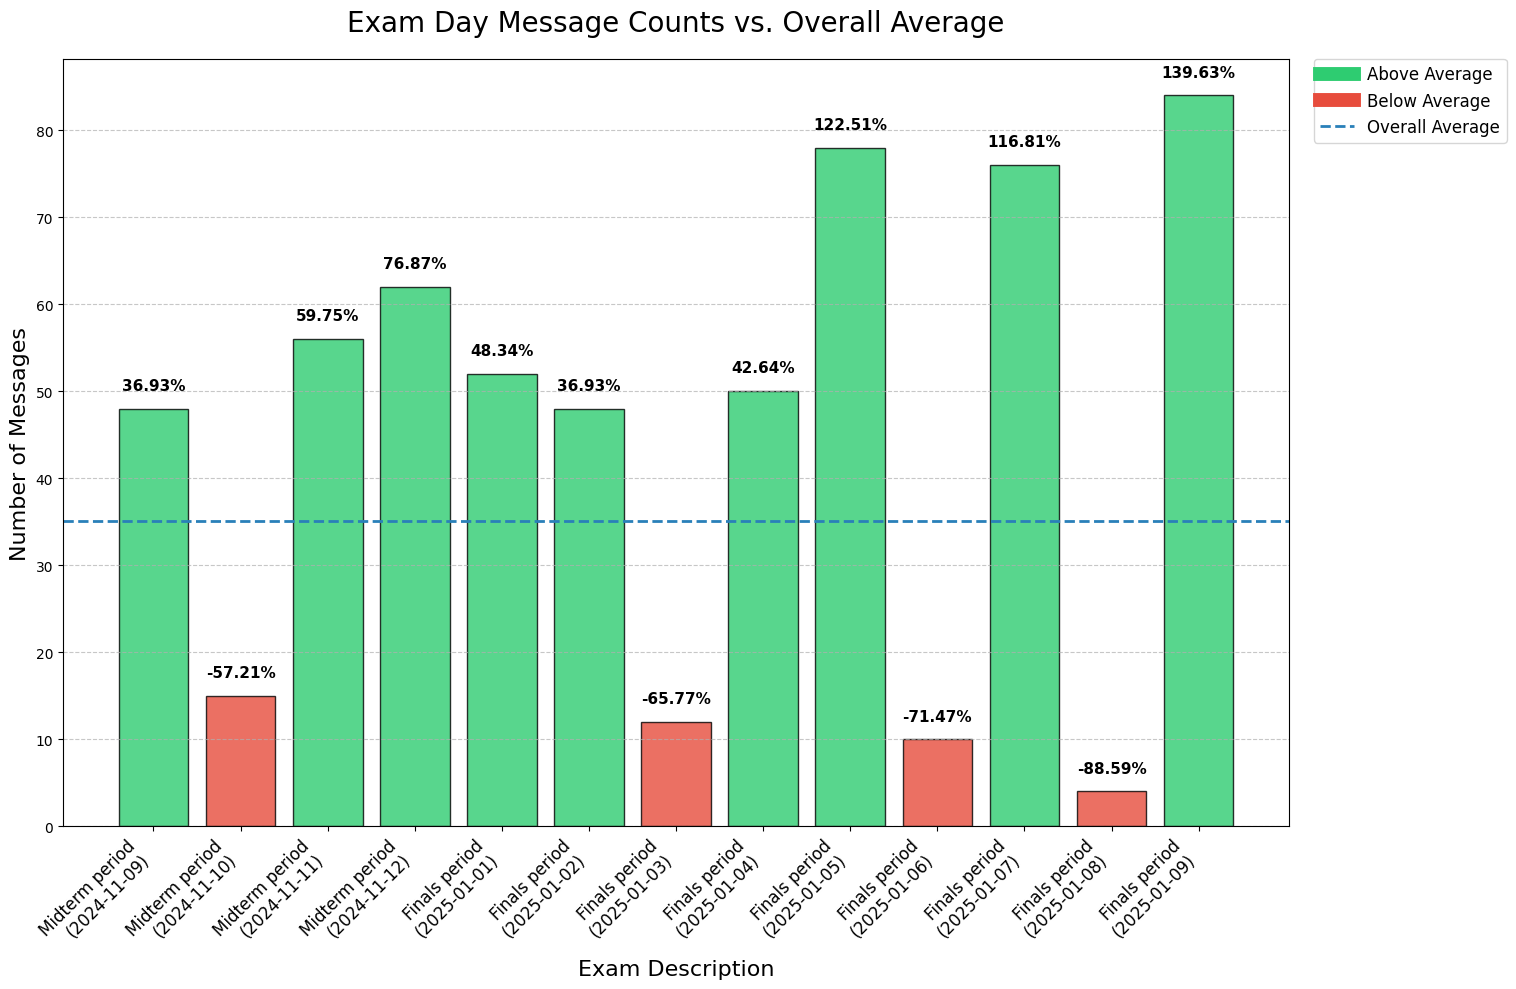


Daily Message Statistics:
Minimum messages per day: 1
Maximum messages per day: 181
Median messages per day: 26.0
Standard deviation: 32.89


In [10]:
# Create a DataFrame with message timestamps
messages_data = []
for msg_id in mapping_df['user_message_id'].dropna():
    if msg_id in message_dict:
        msg = message_dict[msg_id]
        timestamp = msg.get('message_create_time')
        if timestamp is not None:
            messages_data.append({
                'message_id': msg_id,
                'datetime': pd.to_datetime(timestamp)  # Ensure datetime format
            })

df_messages = pd.DataFrame(messages_data)

# Extract date from 'datetime'
df_messages['date'] = df_messages['datetime'].dt.date

# Calculate total messages per day
messages_per_day = df_messages.groupby('date').size().reset_index(name='message_count')

# Calculate overall average messages per day
average_messages = messages_per_day['message_count'].mean()

# Define exam days with descriptions
exam_days = [
    {'exam_date': '2024-11-09', 'description': 'Midterm period'},
    {'exam_date': '2024-11-10', 'description': 'Midterm period'},
    {'exam_date': '2024-11-11', 'description': 'Midterm period'},
    {'exam_date': '2024-11-12', 'description': 'Midterm period'},
 
    {'exam_date': '2025-01-01', 'description': 'Finals period'},
    {'exam_date': '2025-01-02', 'description': 'Finals period'},
    {'exam_date': '2025-01-03', 'description': 'Finals period'},
    {'exam_date': '2025-01-04', 'description': 'Finals period'},
    {'exam_date': '2025-01-05', 'description': 'Finals period'},
    {'exam_date': '2025-01-06', 'description': 'Finals period'},
    {'exam_date': '2025-01-07', 'description': 'Finals period'},
    {'exam_date': '2025-01-08', 'description': 'Finals period'},
    {'exam_date': '2025-01-09', 'description': 'Finals period'},
]

# Convert exam_date strings to datetime.date objects
for exam in exam_days:
    exam['exam_date'] = datetime.strptime(exam['exam_date'], '%Y-%m-%d').date()

# Calculate messages on each exam day
exam_message_counts = []
for exam in exam_days:
    exam_date = exam['exam_date']
    description = exam['description']
    
    # Filter messages sent on the exam day
    messages_on_exam_day = messages_per_day[messages_per_day['date'] == exam_date]
    
    # Total messages sent on the exam day
    if not messages_on_exam_day.empty:
        total_messages = messages_on_exam_day.iloc[0]['message_count']
    else:
        total_messages = 0  # No messages on this day
    
    # Calculate percentage difference from overall average
    percentage_difference = ((total_messages - average_messages) / average_messages) * 100 if average_messages > 0 else 0
    
    # Determine comparison
    comparison = 'Above Average' if percentage_difference > 0 else 'Below Average'
    
    # Append to the list
    exam_message_counts.append({
        'Exam_Date': exam_date.strftime('%Y-%m-%d'),
        'Description': description,
        'Total_Messages': total_messages,
        'Percentage_Difference': round(percentage_difference, 2),
        'Comparison': comparison
    })

# Create DataFrame from the list
df_exam_analysis = pd.DataFrame(exam_message_counts)

# Create a combined label with Description and Exam_Date
df_exam_analysis['Label'] = df_exam_analysis.apply(
    lambda row: f"{row['Description']}\n({row['Exam_Date']})", axis=1
)

# ----------------------- Display Analysis -----------------------

# Display the analysis table
print("\nOverall Average Messages per Day:", round(average_messages, 2))
print("\nExam Day Message Analysis:")
print(df_exam_analysis[['Exam_Date', 'Description', 'Total_Messages', 
                        'Percentage_Difference', 'Comparison']])

# ----------------------- Visualization -----------------------



# Create a figure for the plot
plt.figure(figsize=(18, 10))  # Adjusted figure size to accommodate labels and legend

# --------------------- Bar Plot ---------------------
# Bar plot for Exam Day Message Counts with Average Line

# Define colors based on comparison
colors = df_exam_analysis['Comparison'].map({'Above Average': '#2ecc71', 'Below Average': '#e74c3c'}).fillna('gray')

# Create bar plot
bars = plt.bar(
    range(len(df_exam_analysis)), 
    df_exam_analysis['Total_Messages'], 
    color=colors, 
    edgecolor='black',
    alpha=0.8
)

# Add the average line
plt.axhline(
    y=average_messages, 
    color='#2980b9', 
    linestyle='--', 
    linewidth=2, 
    label=f'Overall Average ({average_messages:.2f})'
)

# Customize the plot
plt.title('Exam Day Message Counts vs. Overall Average', fontsize=20, pad=20)
plt.xlabel('Exam Description', fontsize=16)
plt.ylabel('Number of Messages', fontsize=16)

# Set x-axis labels
plt.xticks(range(len(df_exam_analysis)), df_exam_analysis['Label'], rotation=45, ha='right', fontsize=12)

# Add percentage labels on top of bars
for idx, row in df_exam_analysis.iterrows():
    plt.text(
        idx, 
        row['Total_Messages'] + (messages_per_day['message_count'].max() * 0.01),
        f"{row['Percentage_Difference']}%",
        ha='center', 
        va='bottom', 
        fontsize=11, 
        fontweight='bold'
    )

# Add legend outside the plot
legend_elements = [
    plt.Line2D([0], [0], color='#2ecc71', lw=10, label='Above Average'),
    plt.Line2D([0], [0], color='#e74c3c', lw=10, label='Below Average'),
    plt.Line2D([0], [0], color='#2980b9', linestyle='--', lw=2, label='Overall Average')
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=12)

# Enhance layout
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping, especially with the external legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Allocate space on the right for the legend

# Show the plot
plt.show()

# ----------------------- Daily Statistics -----------------------

# Print daily message statistics
print("\nDaily Message Statistics:")
print(f"Minimum messages per day: {messages_per_day['message_count'].min()}")
print(f"Maximum messages per day: {messages_per_day['message_count'].max()}")
print(f"Median messages per day: {messages_per_day['message_count'].median()}")
print(f"Standard deviation: {messages_per_day['message_count'].std():.2f}")


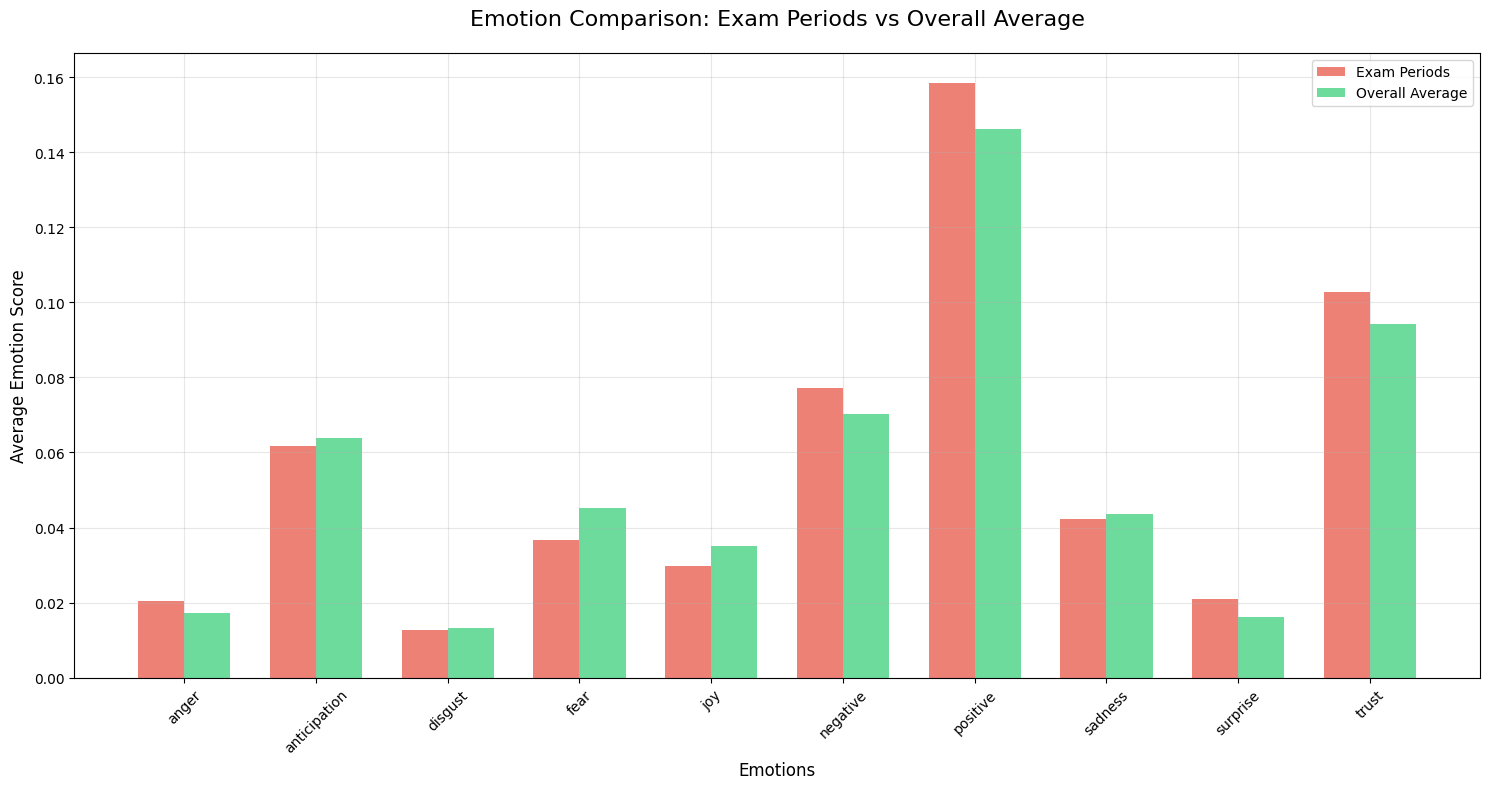

In [11]:

def simple_tokenize(text):
    """A simple tokenization function that splits text into words."""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    return [word for word in text.split() if word.strip()]

def load_nrc_lexicon(file_path):
    """Load and process the NRC emotion lexicon."""
    try:
        nrc_df = pd.read_csv(file_path, sep='\t', names=['word', 'emotion', 'value'])
        nrc_matrix = nrc_df.pivot(index='word', columns='emotion', values='value')
        return nrc_matrix
    except Exception as e:
        print(f"Error loading NRC lexicon: {str(e)}")
        return None

def get_messages_for_date(date, message_dict, mapping_df):
    """Get all user messages for a specific date."""
    messages = []
    for msg_id in mapping_df['user_message_id'].dropna():
        if msg_id in message_dict:
            msg = message_dict[msg_id]
            msg_time = msg.get('message_create_time')
            if msg_time and msg_time.date() == date:
                content = msg.get('content', '')
                if isinstance(content, str):
                    messages.append(content.lower())
    return ' '.join(messages)

def get_all_messages(message_dict, mapping_df):
    """Get all messages grouped by date."""
    messages_by_date = {}
    for msg_id in mapping_df['user_message_id'].dropna():
        if msg_id in message_dict:
            msg = message_dict[msg_id]
            msg_time = msg.get('message_create_time')
            if msg_time:
                date = msg_time.date()
                content = msg.get('content', '')
                if isinstance(content, str):
                    if date not in messages_by_date:
                        messages_by_date[date] = []
                    messages_by_date[date].append(content.lower())
    
    return {date: ' '.join(msgs) for date, msgs in messages_by_date.items()}

def analyze_emotions(text, nrc_matrix):
    """Analyze emotions in text using NRC lexicon."""
    if nrc_matrix is None:
        return None, None
    
    words = simple_tokenize(text)
    emotions = {col: 0 for col in nrc_matrix.columns}
    word_count = 0
    emotional_words = {emotion: [] for emotion in emotions.keys()}
    
    for word in words:
        if word in nrc_matrix.index:
            word_count += 1
            for emotion in emotions.keys():
                if nrc_matrix.loc[word, emotion] > 0:
                    emotions[emotion] += 1
                    emotional_words[emotion].append(word)
    
    if word_count > 0:
        emotions = {k: v/word_count for k, v in emotions.items()}
    
    return emotions, emotional_words

def analyze_all_emotions(message_dict, mapping_df, nrc_matrix):
    """Analyze emotions for all messages."""
    all_messages = get_all_messages(message_dict, mapping_df)
    emotion_data = []
    
    for date, messages in all_messages.items():
        emotions, _ = analyze_emotions(messages, nrc_matrix)
        if emotions:
            emotions['date'] = date
            emotions['period'] = 'Regular Period'
            emotion_data.append(emotions)
    
    return pd.DataFrame(emotion_data)

def analyze_exam_period_emotions(exam_days, message_dict, mapping_df, nrc_matrix):
    """Analyze emotions during exam periods."""
    emotion_data = []
    
    for exam in exam_days:
        exam_date = exam['exam_date']
        messages = get_messages_for_date(exam_date, message_dict, mapping_df)
        
        if messages:
            emotions, _ = analyze_emotions(messages, nrc_matrix)
            if emotions:
                emotions['date'] = exam_date
                emotions['period'] = exam['description']
                emotion_data.append(emotions)
    
    return pd.DataFrame(emotion_data)

def plot_emotion_comparison(exam_df, all_df):
    """Create a bar plot comparing exam period emotions with overall averages."""
    emotion_columns = [col for col in exam_df.columns if col not in ['date', 'period']]
    
    # Calculate averages
    exam_means = exam_df.groupby('period')[emotion_columns].mean()
    all_means = all_df[emotion_columns].mean()
    
    # Prepare data for plotting
    comparison_data = pd.DataFrame({
        'Exam Periods': exam_means.mean(),
        'Overall Average': all_means
    })
    
    # Create grouped bar plot
    plt.figure(figsize=(15, 8))
    x = np.arange(len(emotion_columns))
    width = 0.35
    
    plt.bar(x - width/2, comparison_data['Exam Periods'], width, label='Exam Periods', color='#e74c3c', alpha=0.7)
    plt.bar(x + width/2, comparison_data['Overall Average'], width, label='Overall Average', color='#2ecc71', alpha=0.7)
    
    plt.title('Emotion Comparison: Exam Periods vs Overall Average', fontsize=16, pad=20)
    plt.xlabel('Emotions', fontsize=12)
    plt.ylabel('Average Emotion Score', fontsize=12)
    plt.xticks(x, emotion_columns, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def print_comparison_summary(exam_df, all_df):
    """Print detailed comparison of emotions between exam periods and overall average."""
    emotion_columns = [col for col in exam_df.columns if col not in ['date', 'period']]

    # Calculate statistics
    exam_means = exam_df.groupby('period')[emotion_columns].mean()
    all_means = all_df[emotion_columns].mean()
  

# Example usage
try:
    nrc_matrix = load_nrc_lexicon('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    if nrc_matrix is not None:
        # Analyze emotions for exam periods and all periods
        exam_emotion_df = analyze_exam_period_emotions(exam_days, message_dict, mapping_df, nrc_matrix)
        all_emotion_df = analyze_all_emotions(message_dict, mapping_df, nrc_matrix)
        
        # Generate visualizations
        plot_emotion_comparison(exam_emotion_df, all_emotion_df)
        print_comparison_summary(exam_emotion_df, all_emotion_df)
    else:
        print("Failed to load NRC lexicon. Please check the file path and format.")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please check if all required files are in the correct location and format.")


    
    

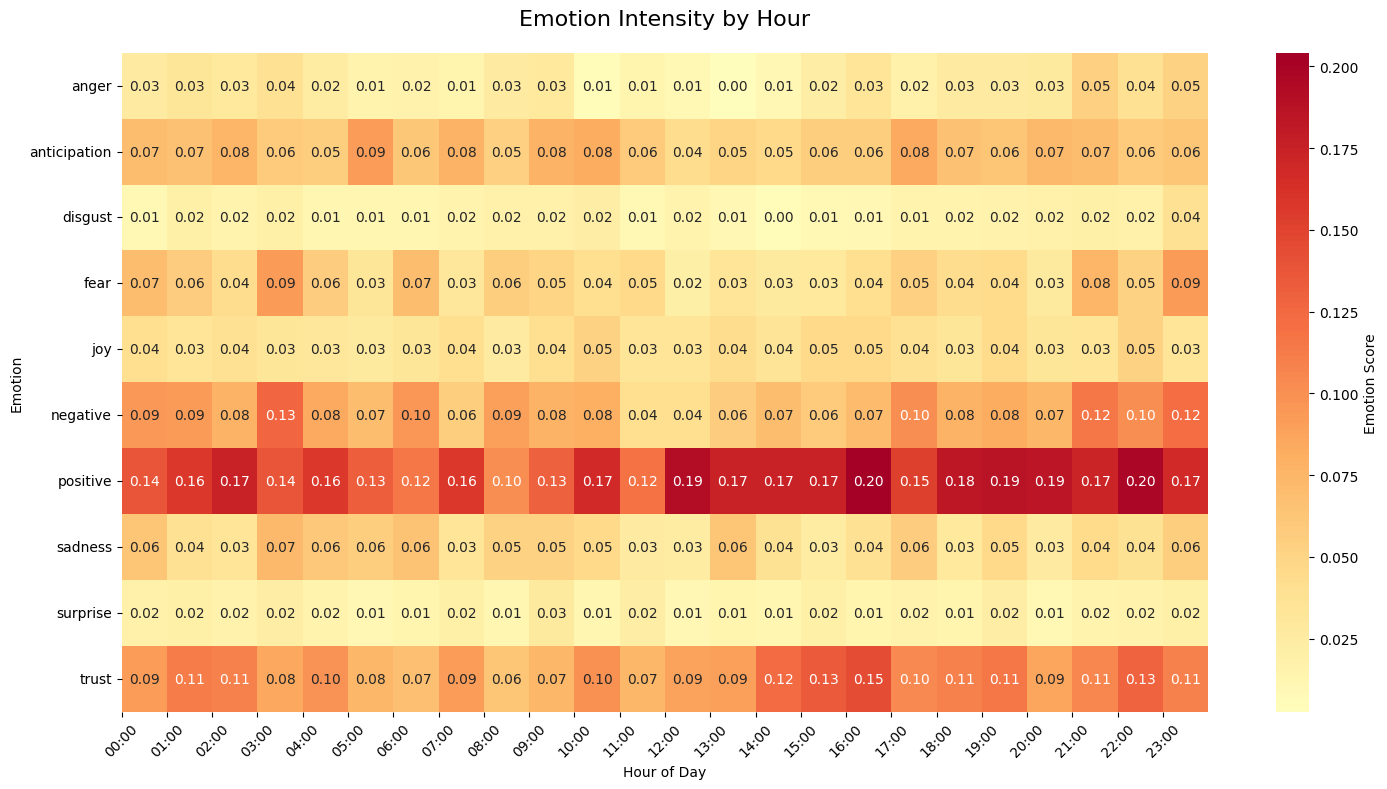

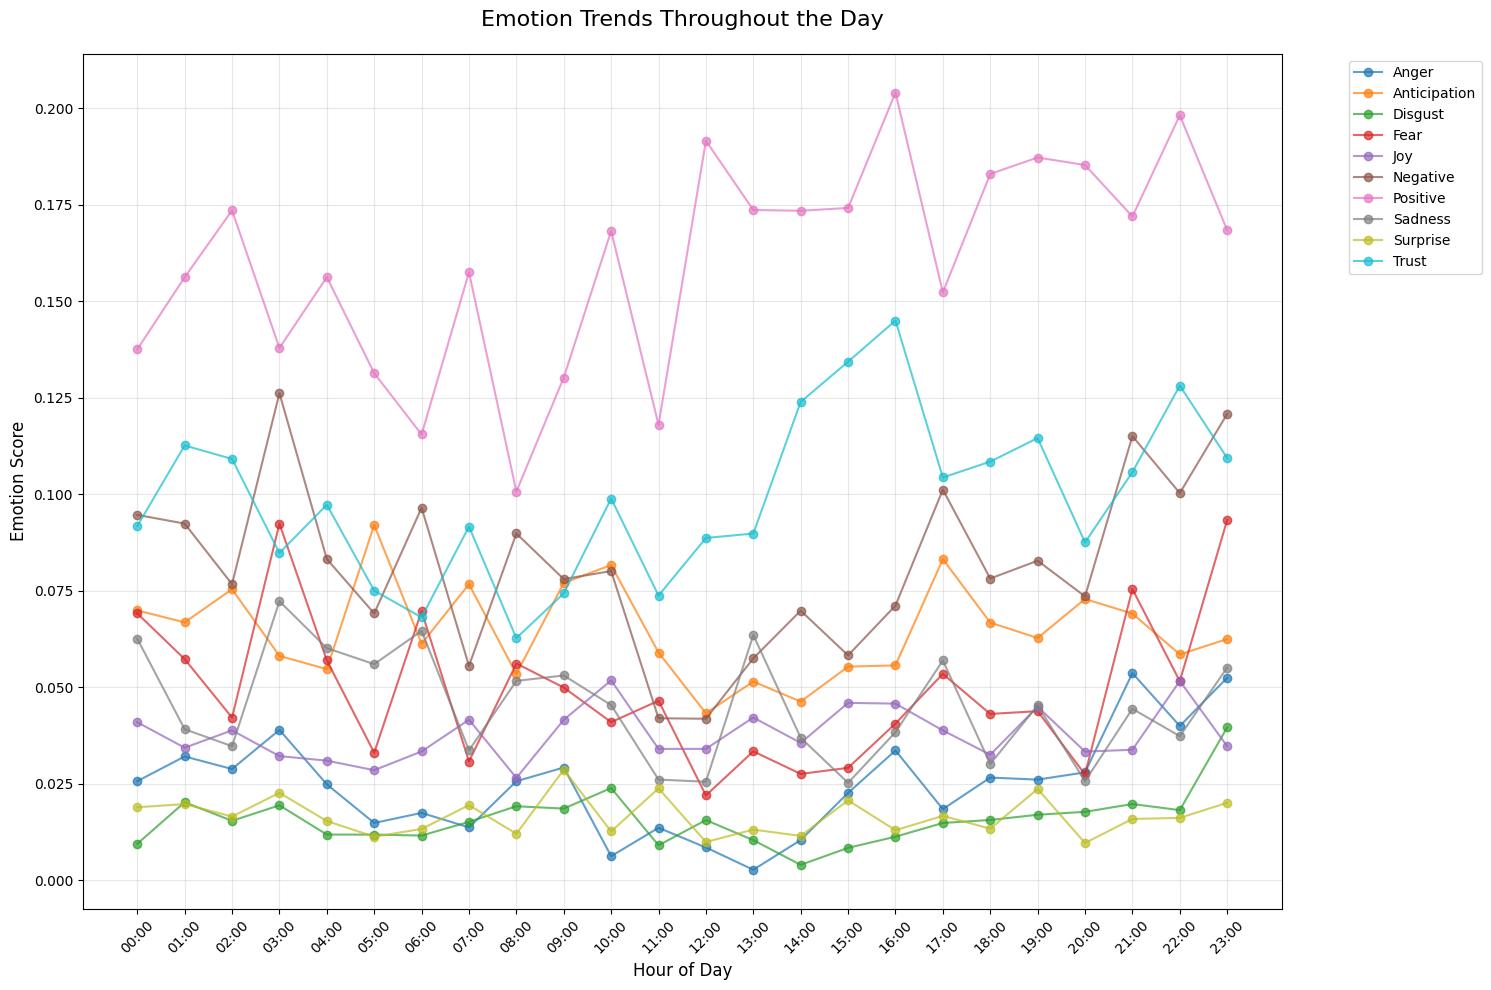

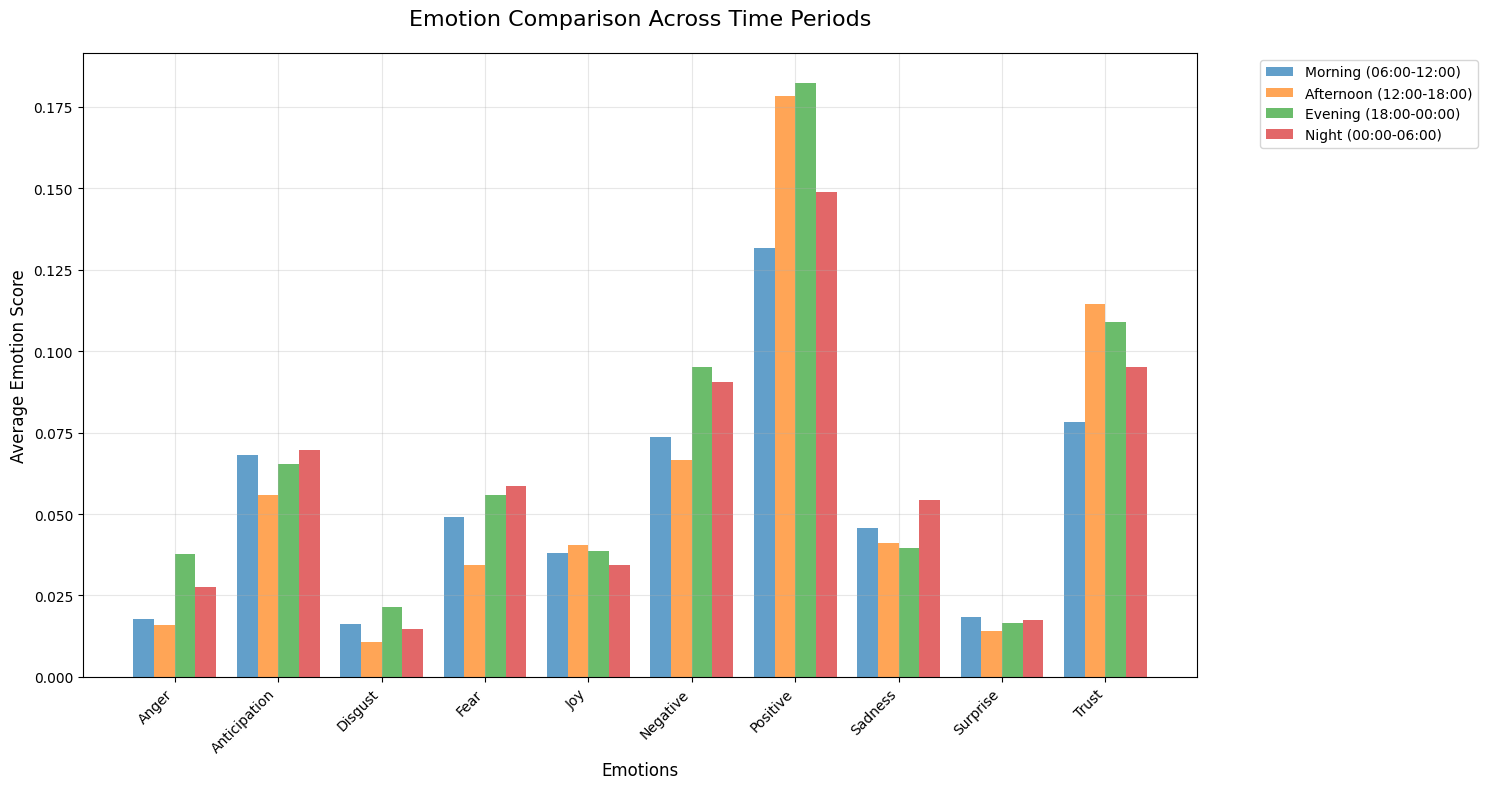


Emotion Statistics by Time Period:

Morning (06:00-12:00):
  Anger: 0.018
  Anticipation: 0.068
  Disgust: 0.016
  Fear: 0.049
  Joy: 0.038
  Negative: 0.074
  Positive: 0.132
  Sadness: 0.046
  Surprise: 0.018
  Trust: 0.078

Afternoon (12:00-18:00):
  Anger: 0.016
  Anticipation: 0.056
  Disgust: 0.011
  Fear: 0.034
  Joy: 0.040
  Negative: 0.067
  Positive: 0.178
  Sadness: 0.041
  Surprise: 0.014
  Trust: 0.114

Evening (18:00-00:00):
  Anger: 0.038
  Anticipation: 0.065
  Disgust: 0.021
  Fear: 0.056
  Joy: 0.039
  Negative: 0.095
  Positive: 0.182
  Sadness: 0.040
  Surprise: 0.016
  Trust: 0.109

Night (00:00-06:00):
  Anger: 0.028
  Anticipation: 0.070
  Disgust: 0.015
  Fear: 0.059
  Joy: 0.034
  Negative: 0.090
  Positive: 0.149
  Sadness: 0.054
  Surprise: 0.017
  Trust: 0.095


In [13]:
import pytz
def get_messages_for_hour(hour, message_dict, mapping_df):
    """Get all messages for a specific hour."""
    turkey_tz = pytz.timezone('Europe/Istanbul')
    messages = []
    
    for msg_id in mapping_df['user_message_id'].dropna():
        if msg_id in message_dict:
            msg = message_dict[msg_id]
            timestamp = msg.get('message_create_time')
            if timestamp is not None:
                # Convert to Turkey timezone
                turkey_time = timestamp.tz_localize(pytz.UTC).tz_convert(turkey_tz)
                if turkey_time.hour == hour:
                    content = msg.get('content', '')
                    if isinstance(content, str):
                        messages.append(content.lower())
    
    return ' '.join(messages)

def analyze_hourly_emotions(message_dict, mapping_df, nrc_matrix):
    """Analyze emotions by hour."""
    turkey_tz = pytz.timezone('Europe/Istanbul')
    emotion_data = []
    
    # Analyze each hour
    for hour in range(24):
        messages = get_messages_for_hour(hour, message_dict, mapping_df)
        if messages:
            emotions, _ = analyze_emotions(messages, nrc_matrix)
            if emotions:
                emotions['hour'] = hour
                emotion_data.append(emotions)
    
    return pd.DataFrame(emotion_data)

def plot_hourly_emotion_heatmap(hourly_df):
    """Create a heatmap showing emotions by hour."""
    # Prepare data for heatmap
    emotion_columns = [col for col in hourly_df.columns if col not in ['hour']]
    pivot_data = hourly_df.set_index('hour')[emotion_columns]
    
    # Create heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data.T, 
                cmap='RdYlBu_r',
                center=0,
                annot=True,
                fmt='.2f',
                cbar_kws={'label': 'Emotion Score'})
    
    plt.title('Emotion Intensity by Hour', fontsize=16, pad=20)
    plt.xlabel('Hour of Day')
    plt.ylabel('Emotion')
    
    # Format hour labels
    plt.xticks(range(24), [f"{hour:02d}:00" for hour in range(24)], 
               rotation=45)
    
    plt.tight_layout()
    plt.show()

def plot_hourly_emotion_lines(hourly_df):
    """Create line plots showing emotion trends throughout the day."""
    emotion_columns = [col for col in hourly_df.columns if col not in ['hour']]
    
    plt.figure(figsize=(15, 10))
    
    # Plot each emotion
    for emotion in emotion_columns:
        plt.plot(hourly_df['hour'], 
                hourly_df[emotion], 
                marker='o', 
                label=emotion.title(),
                alpha=0.7)
    
    plt.title('Emotion Trends Throughout the Day', fontsize=16, pad=20)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Emotion Score', fontsize=12)
    
    # Format x-axis
    plt.xticks(range(24), [f"{hour:02d}:00" for hour in range(24)], 
               rotation=45)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_time_periods(hourly_df):
    """Analyze emotions across different time periods of the day."""
    emotion_columns = [col for col in hourly_df.columns if col not in ['hour']]
    
    # Define time periods
    periods = {
        'Morning (06:00-12:00)': (6, 12),
        'Afternoon (12:00-18:00)': (12, 18),
        'Evening (18:00-00:00)': (18, 24),
        'Night (00:00-06:00)': (0, 6)
    }
    
    period_data = []
    
    for period_name, (start_hour, end_hour) in periods.items():
        period_mask = (hourly_df['hour'] >= start_hour) & (hourly_df['hour'] < end_hour)
        period_avg = hourly_df[period_mask][emotion_columns].mean()
        
        period_data.append({
            'period': period_name,
            **period_avg
        })
    
    period_df = pd.DataFrame(period_data)
    
    # Create comparison plot
    plt.figure(figsize=(15, 8))
    
    # Plot each period
    x = np.arange(len(emotion_columns))
    width = 0.2
    
    for i, period in enumerate(periods.keys()):
        values = period_df[period_df['period'] == period][emotion_columns].values[0]
        plt.bar(x + i*width, values, width, label=period, alpha=0.7)
    
    plt.title('Emotion Comparison Across Time Periods', fontsize=16, pad=20)
    plt.xlabel('Emotions', fontsize=12)
    plt.ylabel('Average Emotion Score', fontsize=12)
    
    plt.xticks(x + width*1.5, [col.title() for col in emotion_columns], 
               rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return period_df
try:
    nrc_matrix = load_nrc_lexicon('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    if nrc_matrix is not None:
        # Analyze emotions by hour
        hourly_emotion_df = analyze_hourly_emotions(message_dict, mapping_df, nrc_matrix)
        
        # Generate visualizations
        plot_hourly_emotion_heatmap(hourly_emotion_df)
        plot_hourly_emotion_lines(hourly_emotion_df)
        
        # Analyze time periods
        period_emotion_df = analyze_time_periods(hourly_emotion_df)
        
        # Print detailed statistics
        print("\nEmotion Statistics by Time Period:")
        print("=================================")
        
        emotion_columns = [col for col in period_emotion_df.columns if col != 'period']
        for period in period_emotion_df['period']:
            print(f"\n{period}:")
            period_data = period_emotion_df[period_emotion_df['period'] == period]
            for emotion in emotion_columns:
                score = period_data[emotion].values[0]
                print(f"  {emotion.title()}: {score:.3f}")
    else:
        print("Failed to load NRC lexicon. Please check the file path and format.")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()